<!-- Portada personalizada en _quarto.yml  -->

# Trabajo de simulación 3

## Consigna

Para el último trabajo de simulación, vamos a hacer un análisis de datos a partir de la encuesta de salarios de Sysarmy del primer trimestre de 2025 (si están publicados los del segundo trimestre o posterior, podemos usar esos, pero a agosto de 2025 todavía no estaban).

Los datos oficiales se encuentran [acá](https://docs.google.com/spreadsheets/d/1hlLwv9SLJvrnsTq_UsEAHkHGNiziH7IdT1lJd4fq6kU/edit?gid=1462536742#gid=1462536742). Por si en algún momento el enlace se cae o cambia de ubicación, una versión alojada en mi drive puede encontrarse [acá](https://docs.google.com/spreadsheets/d/1Vq9F6xE03fR0x6pXlRMDN_bww7NWItjMW0U89qV3AvM/edit?usp=sharing).

Las consignas de este trabajo no son tan dirigidas como las de los trabajos anteriores, pues en el análisis de datos, siempre hay libertad y margen para la creatividad y la producción personal. Sin embargo, les compartimos algunas pautas de lo que debe tener, como mínimo, este trabajo.

Pautas generales y **OBLIGATORIAS** para la aprobación de la entrega:

*   Debe replicarse, como mínimo, un análisis similar al aquí presentado, para estos datos (SysArmy 2025 o cualquier otro dataset que sea de su interés). Por "replicar" nos referimos a que el análisis debe incluir: inspección y limpieza de los datos, descripción y visualización, o estudio de alguna variable de interés a partir de alguna hipótesis o conjetura.

*   Debe escribirse en formato "informe", es decir, no se trata de exhibir código y gráficos, sino de explicar qué se observa y por qué es relevante observar eso. El informe es requisito **excluyente**. No se aprueba el trabajo de simulación sin él. Este informe breve debe entregarse en pdf, en esta entrega **NO** se evalúa el *colab*, sino el reporte. No tiene que ser largo, al contrario, tiene que ser de calidad. Como dice el dicho: lo bueno -si breve- dos veces bueno...

*   El trabajo debe contener, como mínimo, **una conjetura que sea sometida a prueba y de la que se exhiba alguna conclusión fundamentada**, como se hizo en el caso de los datos de 2020 para el salario medio bruto por género y para hombres y mujeres con nivel universitario completo. Por ejemplo, frente a la pregunta de si el salario medio de mujeres y hombres es igual, podríamos poner en práctica lo que estudiamos sobre convergencia para, de alguna forma, darnos una idea de cuán probable es observar lo que efectivamente estamos observando. Este es un "coqueteo" con la estadística inferencial, que no estudiamos formalmente en la materia, pero que es válido comenzar a encarar con todo lo que hemos estudiado. Esta conjetura puede hacerse con datos propios, si es que eligen trabajar con otro dataset.

El resto de la producción queda a criterio de los grupos. Esperamos que haya un interés genuino en tratar de extraer información a partir de estos datos. ¡Muchos éxitos!

**PD: El formato "informe" puede ser cambiado por el formato "póster/infografía" si es que así prefieren.**

## Nuestra resolución: _Optimización salarial_

Para realizar nuestro análisis tomamos la perspectiva de un profesional del sector IT que necesita transfomar su carrera por alguna razón. Sabemos que esta industria se caracteriza por un nivel de rotación alto y los recorridos profesionales suelen ser muy variados. La pregunta central de nuestro trabajo es _¿cómo puedo maximizar mi salario?_, es decir, _¿cuál es la **combinación ganadora** que se podría obtener como insight de este dataset?_ Los resultados obtenidos podrían ser de utilidad tanto para el _junior_, que necesita alguna "brújula" para ver por dónde orientarse dentro del mercado laboral, como para el _senior_ que quizá se siente estancado y necesite reorientar su desarrollo profesional dentro del sector. 

In [1]:
import pandas as pd
import numpy as np
import warnings
import re
warnings.filterwarnings('ignore')

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.model_selection import cross_val_score

# Configuración de visualización
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.size'] = 10
plt.rcParams['figure.titlesize'] = 12
plt.rcParams['axes.titlesize'] = 11
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['xtick.labelsize'] = 9
plt.rcParams['ytick.labelsize'] = 9

### Inspección y limpieza de datos

Comenzamos importando las librerías necesarias y cargando el dataset. Luego inspeccionamos los datos para ver qué variables tenemos disponibles y qué tipo de datos contienen. 

In [2]:
file_path = 'data/Sysarmy_sueldos_2025.01CLEAN.csv'

try:
    df = pd.read_csv(file_path, encoding='utf-8')
    print(f"*** Archivo cargado exitosamente")
    print(f"    Dimensiones: {df.shape[0]} filas x {df.shape[1]} columnas\n")
except FileNotFoundError:
    print(f"ERROR: Archivo no encontrado en '{file_path}'")
    df = None
except Exception as e:
    print(f"ERROR: {e}")
    df = None

if df is None:
    raise Exception("No se pudo cargar el dataset")


*** Archivo cargado exitosamente
    Dimensiones: 5196 filas x 50 columnas



Luego procesamos los datos para dejarlos en un formato adecuado para el análisis. Esto incluye manejar valores faltantes, convertir variables categóricas en numéricas (si es necesario) y asegurarnos de que todas las variables estén en el tipo de dato correcto.

In [3]:
# Renombrar columnas
column_mapping = {
    'donde_estas_trabajando': 'provincia',
    'dedicacion': 'dedicacion',
    'tipo_de_contrato': 'tipo_contrato',
    'ultimo_salario_mensual_o_retiro_bruto_en_pesos_argentinos': 'salario_bruto_ars',
    'ultimo_salario_mensual_o_retiro_neto_en_pesos_argentinos': 'salario_neto_ars',
    'pagos_en_dolares': 'forma_pago',
    'trabajo_de': 'puesto',
    'anos_de_experiencia': 'experiencia',
    'antiguedad_en_la_empresa_actual': 'antiguedad',
    'modalidad_de_trabajo': 'modalidad',
    'cantidad_de_personas_en_tu_organizacion': 'tamano_empresa',
    'tengo_edad': 'edad',
    'genero': 'genero',
    'seniority': 'seniority',
    '_sal': 'salario_ars',
    'cuantas_personas_tenes_a_cargo': 'personas_a_cargo',
    'si_tu_sueldo_esta_dolarizado_cual_fue_el_ultimo_valor_del_dolar_que_tomaron': 'tc_reportado'
}

df_clean = df.rename(columns=column_mapping)

# Convertir a numéricos
df_clean['salario_bruto_ars'] = pd.to_numeric(df_clean['salario_bruto_ars'], errors='coerce')
df_clean['salario_ars'] = pd.to_numeric(df_clean['salario_ars'], errors='coerce')
df_clean['tc_reportado'] = pd.to_numeric(df_clean['tc_reportado'], errors='coerce')

# Calcular salario en USD
print("[PASO 1] Calculando salarios en USD con TC individual...\n")

# Inicializar columna
df_clean['salario_usd'] = np.nan

# Prioridad 1: Usar TC reportado por cada persona
mask_con_tc = (df_clean['tc_reportado'].notna() & 
               (df_clean['tc_reportado'] > 0) & 
               df_clean['salario_ars'].notna())

df_clean.loc[mask_con_tc, 'salario_usd'] = (
    df_clean.loc[mask_con_tc, 'salario_ars'] / df_clean.loc[mask_con_tc, 'tc_reportado']
)

registros_con_tc = mask_con_tc.sum()
print(f"    * {registros_con_tc} registros con TC reportado individual")

# Prioridad 2: Calcular TC mediano para los restantes
tc_mediano = df_clean.loc[df_clean['tc_reportado'] > 0, 'tc_reportado'].median()
print(f"    * TC mediano de la encuesta: ${tc_mediano:,.2f}")

# Aplicar TC mediano a los que no tienen TC reportado
mask_sin_tc = df_clean['salario_usd'].isna() & df_clean['salario_ars'].notna()
if mask_sin_tc.sum() > 0:
    df_clean.loc[mask_sin_tc, 'salario_usd'] = (
        df_clean.loc[mask_sin_tc, 'salario_ars'] / tc_mediano
    )
    print(f"    * {mask_sin_tc.sum()} registros usando TC mediano\n")

# Crear categorías
df_clean['es_caba'] = df_clean['provincia'].apply(
    lambda x: 'CABA' if x == 'Ciudad Autonoma de Buenos Aires' else 'Resto del pais'
)

df_clean['tiene_equipo'] = df_clean['personas_a_cargo'].apply(
    lambda x: 'Con equipo' if pd.notna(x) and x > 0 else 'Sin equipo'
)

print(f"Dataset preparado: {df_clean.shape}")
print(f"Registros con salario USD: {df_clean['salario_usd'].notna().sum()}\n")

[PASO 1] Calculando salarios en USD con TC individual...

    * 927 registros con TC reportado individual
    * TC mediano de la encuesta: $1,060.00
    * 4269 registros usando TC mediano

Dataset preparado: (5196, 53)
Registros con salario USD: 5196



Luego de todo el procesamiento "de rigor" que exige un análisis de datos, nos queda un dataset limpio y listo para analizar. En este punto comenzamos con la búsqueda de "la combinación ganadora", es decir, la combinación de variables que maximiza el salario.

In [4]:
# Dataset para análisis
columnas_analisis = ['salario_usd', 'experiencia', 'es_caba', 'dedicacion',
                     'tipo_contrato', 'puesto', 'seniority', 'modalidad',
                     'edad', 'antiguedad', 'personas_a_cargo', 'forma_pago', 
                     'genero', 'provincia', 'tamano_empresa', 'tiene_equipo']

columnas_analisis = [col for col in columnas_analisis if col in df_clean.columns]
df_analisis = df_clean[columnas_analisis].dropna(subset=['salario_usd'])

print(f"[INFO] Variables analizadas: {len(columnas_analisis)}")
print(f"[INFO] Registros validos: {len(df_analisis)}\n")

[INFO] Variables analizadas: 16
[INFO] Registros validos: 5196



En esta parte realizamos un análisis por variable individual. Tratamos de ir de a poco analizando la información que nos permita responder a la pregunta central del trabajo.

In [5]:
# 1. Ubicación
print("[1] UBICACION GEOGRAFICA:")
ubicacion_stats = df_analisis.groupby('es_caba')['salario_usd'].agg([
    ('Media', 'mean'), ('Mediana', 'median'), ('Q75', lambda x: x.quantile(0.75)),
    ('Max', 'max'), ('Cantidad', 'count')
]).round(2).sort_values('Mediana', ascending=False)
print(ubicacion_stats)
mejor_ubicacion = ubicacion_stats['Mediana'].idxmax()
print(f"\nGANADOR: {mejor_ubicacion}")
print(f"Mediana: ${ubicacion_stats.loc[mejor_ubicacion, 'Mediana']:,.0f} USD\n")

# 2. Tipo de Contrato
print("[2] TIPO DE CONTRATO:")
contrato_stats = df_analisis.groupby('tipo_contrato')['salario_usd'].agg([
    ('Media', 'mean'), ('Mediana', 'median'), ('Q75', lambda x: x.quantile(0.75)),
    ('Max', 'max'), ('Cantidad', 'count')
]).round(2).sort_values('Mediana', ascending=False)
print(contrato_stats)
mejor_contrato = contrato_stats['Mediana'].idxmax()
print(f"\nGANADOR: {mejor_contrato}")
print(f"Mediana: ${contrato_stats.loc[mejor_contrato, 'Mediana']:,.0f} USD\n")

# 3. Dedicación
print("[3] DEDICACION:")
dedicacion_stats = df_analisis.groupby('dedicacion')['salario_usd'].agg([
    ('Media', 'mean'), ('Mediana', 'median'), ('Q75', lambda x: x.quantile(0.75)),
    ('Max', 'max'), ('Cantidad', 'count')
]).round(2).sort_values('Mediana', ascending=False)
print(dedicacion_stats)
mejor_dedicacion = dedicacion_stats['Mediana'].idxmax()
print(f"\nGANADOR: {mejor_dedicacion}")
print(f"Mediana: ${dedicacion_stats.loc[mejor_dedicacion, 'Mediana']:,.0f} USD\n")

# 4. Modalidad
print("[4] MODALIDAD DE TRABAJO:")
modalidad_stats = df_analisis.groupby('modalidad')['salario_usd'].agg([
    ('Media', 'mean'), ('Mediana', 'median'), ('Q75', lambda x: x.quantile(0.75)),
    ('Max', 'max'), ('Cantidad', 'count')
]).round(2).sort_values('Mediana', ascending=False)
print(modalidad_stats)
mejor_modalidad = modalidad_stats['Mediana'].idxmax()
print(f"\nGANADOR: {mejor_modalidad}")
print(f"Mediana: ${modalidad_stats.loc[mejor_modalidad, 'Mediana']:,.0f} USD\n")

# 5. Seniority
print("[5] SENIORITY:")
seniority_stats = df_analisis.groupby('seniority')['salario_usd'].agg([
    ('Media', 'mean'), ('Mediana', 'median'), ('Q75', lambda x: x.quantile(0.75)),
    ('Max', 'max'), ('Cantidad', 'count')
]).round(2).sort_values('Mediana', ascending=False)
print(seniority_stats)
mejor_seniority = seniority_stats['Mediana'].idxmax()
print(f"\nGANADOR: {mejor_seniority}")
print(f"Mediana: ${seniority_stats.loc[mejor_seniority, 'Mediana']:,.0f} USD\n")

# 6. Puesto
print("[6] PUESTO (Top 10):")
puesto_stats = df_analisis.groupby('puesto')['salario_usd'].agg([
    ('Media', 'mean'), ('Mediana', 'median'), ('Q75', lambda x: x.quantile(0.75)),
    ('Max', 'max'), ('Cantidad', 'count')
]).round(2).sort_values('Mediana', ascending=False).head(10)
print(puesto_stats)
mejor_puesto = puesto_stats['Mediana'].idxmax()
print(f"GANADOR: {mejor_puesto}")
print(f"Mediana: ${puesto_stats.loc[mejor_puesto, 'Mediana']:,.0f} USD\n")

# 7. Forma de Pago
print("[7] FORMA DE PAGO:")
pago_stats = df_analisis.groupby('forma_pago')['salario_usd'].agg([
    ('Media', 'mean'), ('Mediana', 'median'), ('Q75', lambda x: x.quantile(0.75)),
    ('Max', 'max'), ('Cantidad', 'count')
]).round(2).sort_values('Mediana', ascending=False)
print(pago_stats)
mejor_pago = pago_stats['Mediana'].idxmax()
print(f"\nGANADOR: {mejor_pago}")
print(f"Mediana: ${pago_stats.loc[mejor_pago, 'Mediana']:,.0f} USD\n")

# 8. Tamaño de Empresa
print("[8] TAMANO DE EMPRESA:")
empresa_stats = df_analisis.groupby('tamano_empresa')['salario_usd'].agg([
    ('Media', 'mean'), ('Mediana', 'median'), ('Q75', lambda x: x.quantile(0.75)),
    ('Max', 'max'), ('Cantidad', 'count')
]).round(2).sort_values('Mediana', ascending=False)
print(empresa_stats)
mejor_empresa = empresa_stats['Mediana'].idxmax()
print(f"\nGANADOR: {mejor_empresa}")
print(f"Mediana: ${empresa_stats.loc[mejor_empresa, 'Mediana']:,.0f} USD\n")

# 9. Equipo
print("[9] PERSONAS A CARGO:")
equipo_stats = df_analisis.groupby('tiene_equipo')['salario_usd'].agg([
    ('Media', 'mean'), ('Mediana', 'median'), ('Q75', lambda x: x.quantile(0.75)),
    ('Max', 'max'), ('Cantidad', 'count')
]).round(2).sort_values('Mediana', ascending=False)
print(equipo_stats)
mejor_equipo = equipo_stats['Mediana'].idxmax()
print(f"\nGANADOR: {mejor_equipo}")
print(f"Mediana: ${equipo_stats.loc[mejor_equipo, 'Mediana']:,.0f} USD\n")

[1] UBICACION GEOGRAFICA:
                  Media  Mediana      Q75         Max  Cantidad
es_caba                                                        
Resto del pais  5324.79  2124.29  3275.33  3885135.14      5196

GANADOR: Resto del pais
Mediana: $2,124 USD

[2] TIPO DE CONTRATO:
                                                       Media  Mediana  \
tipo_contrato                                                           
Contractor                                          11316.76  2641.51   
Staff (planta permanente)                            4477.06  2169.81   
Participación societaria en una cooperativa          2206.28  2075.47   
Tercerizado (trabajo a través de consultora o a...   1869.14  1600.73   
Freelance                                            1895.63  1391.51   

                                                        Q75         Max  \
tipo_contrato                                                             
Contractor                                          

### El perfil del top 10%

Si bien nuestro objetivo es encontrar la combinación ganadora, creemos que un buen punto de partida es analizar el perfil del top 10% con el mejor salario. La idea es entender qué características tienen en común los profesionales que están en este grupo y ver si podemos extraer alguna conclusión útil para nuestro análisis.

In [6]:
percentil_90 = df_analisis['salario_usd'].quantile(0.90)
top_10_percent = df_analisis[df_analisis['salario_usd'] >= percentil_90]

print(f"*** Salario minimo Top 10%: ${percentil_90:,.0f} USD")
print(f"*** Trabajadores en Top 10%: {len(top_10_percent)}\n")

print("[Distribucion Top 10%]\n")
print("Ubicacion:")
print(top_10_percent['es_caba'].value_counts(normalize=True).mul(100).round(1))
print("\nTipo de Contrato:")
print(top_10_percent['tipo_contrato'].value_counts(normalize=True).mul(100).round(1))
print("\nSeniority:")
print(top_10_percent['seniority'].value_counts(normalize=True).mul(100).round(1))
print("\nTop 5 Puestos:")
print(top_10_percent['puesto'].value_counts().head(5))
print(f"\nExperiencia promedio: {top_10_percent['experiencia'].mean():.1f} anos")
print(f"Edad promedio: {top_10_percent['edad'].mean():.1f} anos")
print(f"Antiguedad promedio: {top_10_percent['antiguedad'].mean():.1f} anos\n")

*** Salario minimo Top 10%: $4,717 USD
*** Trabajadores en Top 10%: 530

[Distribucion Top 10%]

Ubicacion:
es_caba
Resto del pais    100.0
Name: proportion, dtype: float64

Tipo de Contrato:
tipo_contrato
Staff (planta permanente)                                 59.6
Contractor                                                35.1
Tercerizado (trabajo a través de consultora o agencia)     2.8
Freelance                                                  2.5
Name: proportion, dtype: float64

Seniority:
seniority
Senior         88.1
Semi-Senior    10.4
Junior          1.5
Name: proportion, dtype: float64

Top 5 Puestos:
puesto
Developer                  129
Manager / Director         116
Technical Leader            81
SysAdmin / DevOps / SRE     49
Architect                   39
Name: count, dtype: int64

Experiencia promedio: 14.3 anos
Edad promedio: 38.8 anos
Antiguedad promedio: 4.6 anos



### El "salto salarial" en la trayectoria profesional

De a poco vemos emerger la infomación relevante. Una vez que analizamos las variables anteriores, podemos abordar la cuestión de la "trayectoria profesional" para encontrar el momento del **salto salarial**, _¿suele tardar en llegar?_, _¿llega en algún momento o tiende más a bien a ser estable?_. Esto es lo que intentamos responder a continuación.

In [7]:
df_analisis['rango_exp'] = pd.cut(
    df_analisis['experiencia'], 
    bins=[0, 2, 5, 8, 12, 100],
    labels=['0-2 años (Junior)', '3-5 años (Semi-Senior)', 
            '6-8 años (Senior)', '9-12 años (Senior+)', '12+ años (Expert)']
)

trayectoria = df_analisis.groupby('rango_exp', observed=True)['salario_usd'].agg([
    ('Cantidad', 'count'), ('Mínimo', 'min'), ('Q25', lambda x: x.quantile(0.25)),
    ('Mediana', 'median'), ('Media', 'mean'), ('Q75', lambda x: x.quantile(0.75)),
    ('Máximo', 'max'), ('Desv_Est', 'std')
]).round(2)

trayectoria['Crecimiento_%'] = trayectoria['Mediana'].pct_change() * 100
trayectoria['Acumulado_%'] = ((trayectoria['Mediana'] / trayectoria['Mediana'].iloc[0]) - 1) * 100

print("EVOLUCIÓN SALARIAL POR EXPERIENCIA:\n")
print(trayectoria)

crecimiento_limpio = trayectoria['Crecimiento_%'].dropna()
if len(crecimiento_limpio) > 0:
    mayor_salto = crecimiento_limpio.idxmax()
    valor_salto = crecimiento_limpio.max()
    print(f"\nMAYOR SALTO SALARIAL: {mayor_salto} (+{valor_salto:.1f}%)\n")

EVOLUCIÓN SALARIAL POR EXPERIENCIA:

                        Cantidad  Mínimo      Q25  Mediana    Media      Q75  \
rango_exp                                                                      
0-2 años (Junior)            754  145.94   935.49  1273.16  2637.31  1756.84   
3-5 años (Semi-Senior)      1634    1.00  1389.47  1886.79  3716.79  2641.51   
6-8 años (Senior)            685    1.25  1840.20  2688.68  8085.04  3653.85   
9-12 años (Senior+)          608    1.37  1886.79  2754.73  3124.81  3920.56   
12+ años (Expert)           1355  145.99  1981.13  2978.77  8839.40  4339.62   

                            Máximo   Desv_Est  Crecimiento_%  Acumulado_%  
rango_exp                                                                  
0-2 años (Junior)        909118.18   33065.23            NaN     0.000000  
3-5 años (Semi-Senior)  2600000.00   64278.19      48.197399    48.197399  
6-8 años (Senior)       3500000.00  133633.65      42.500225   111.181627  
9-12 años (Senior+)   

### Evolución del salario a través de los años

Podemos visualizar la evolución del salario mediano a lo largo de los años de experiencia para observar tendencias y patrones en el crecimiento salarial. También podemos analizar la distribución de salarios en diferentes rangos de experiencia para ver cómo varía el salario entre profesionales con diferentes niveles.

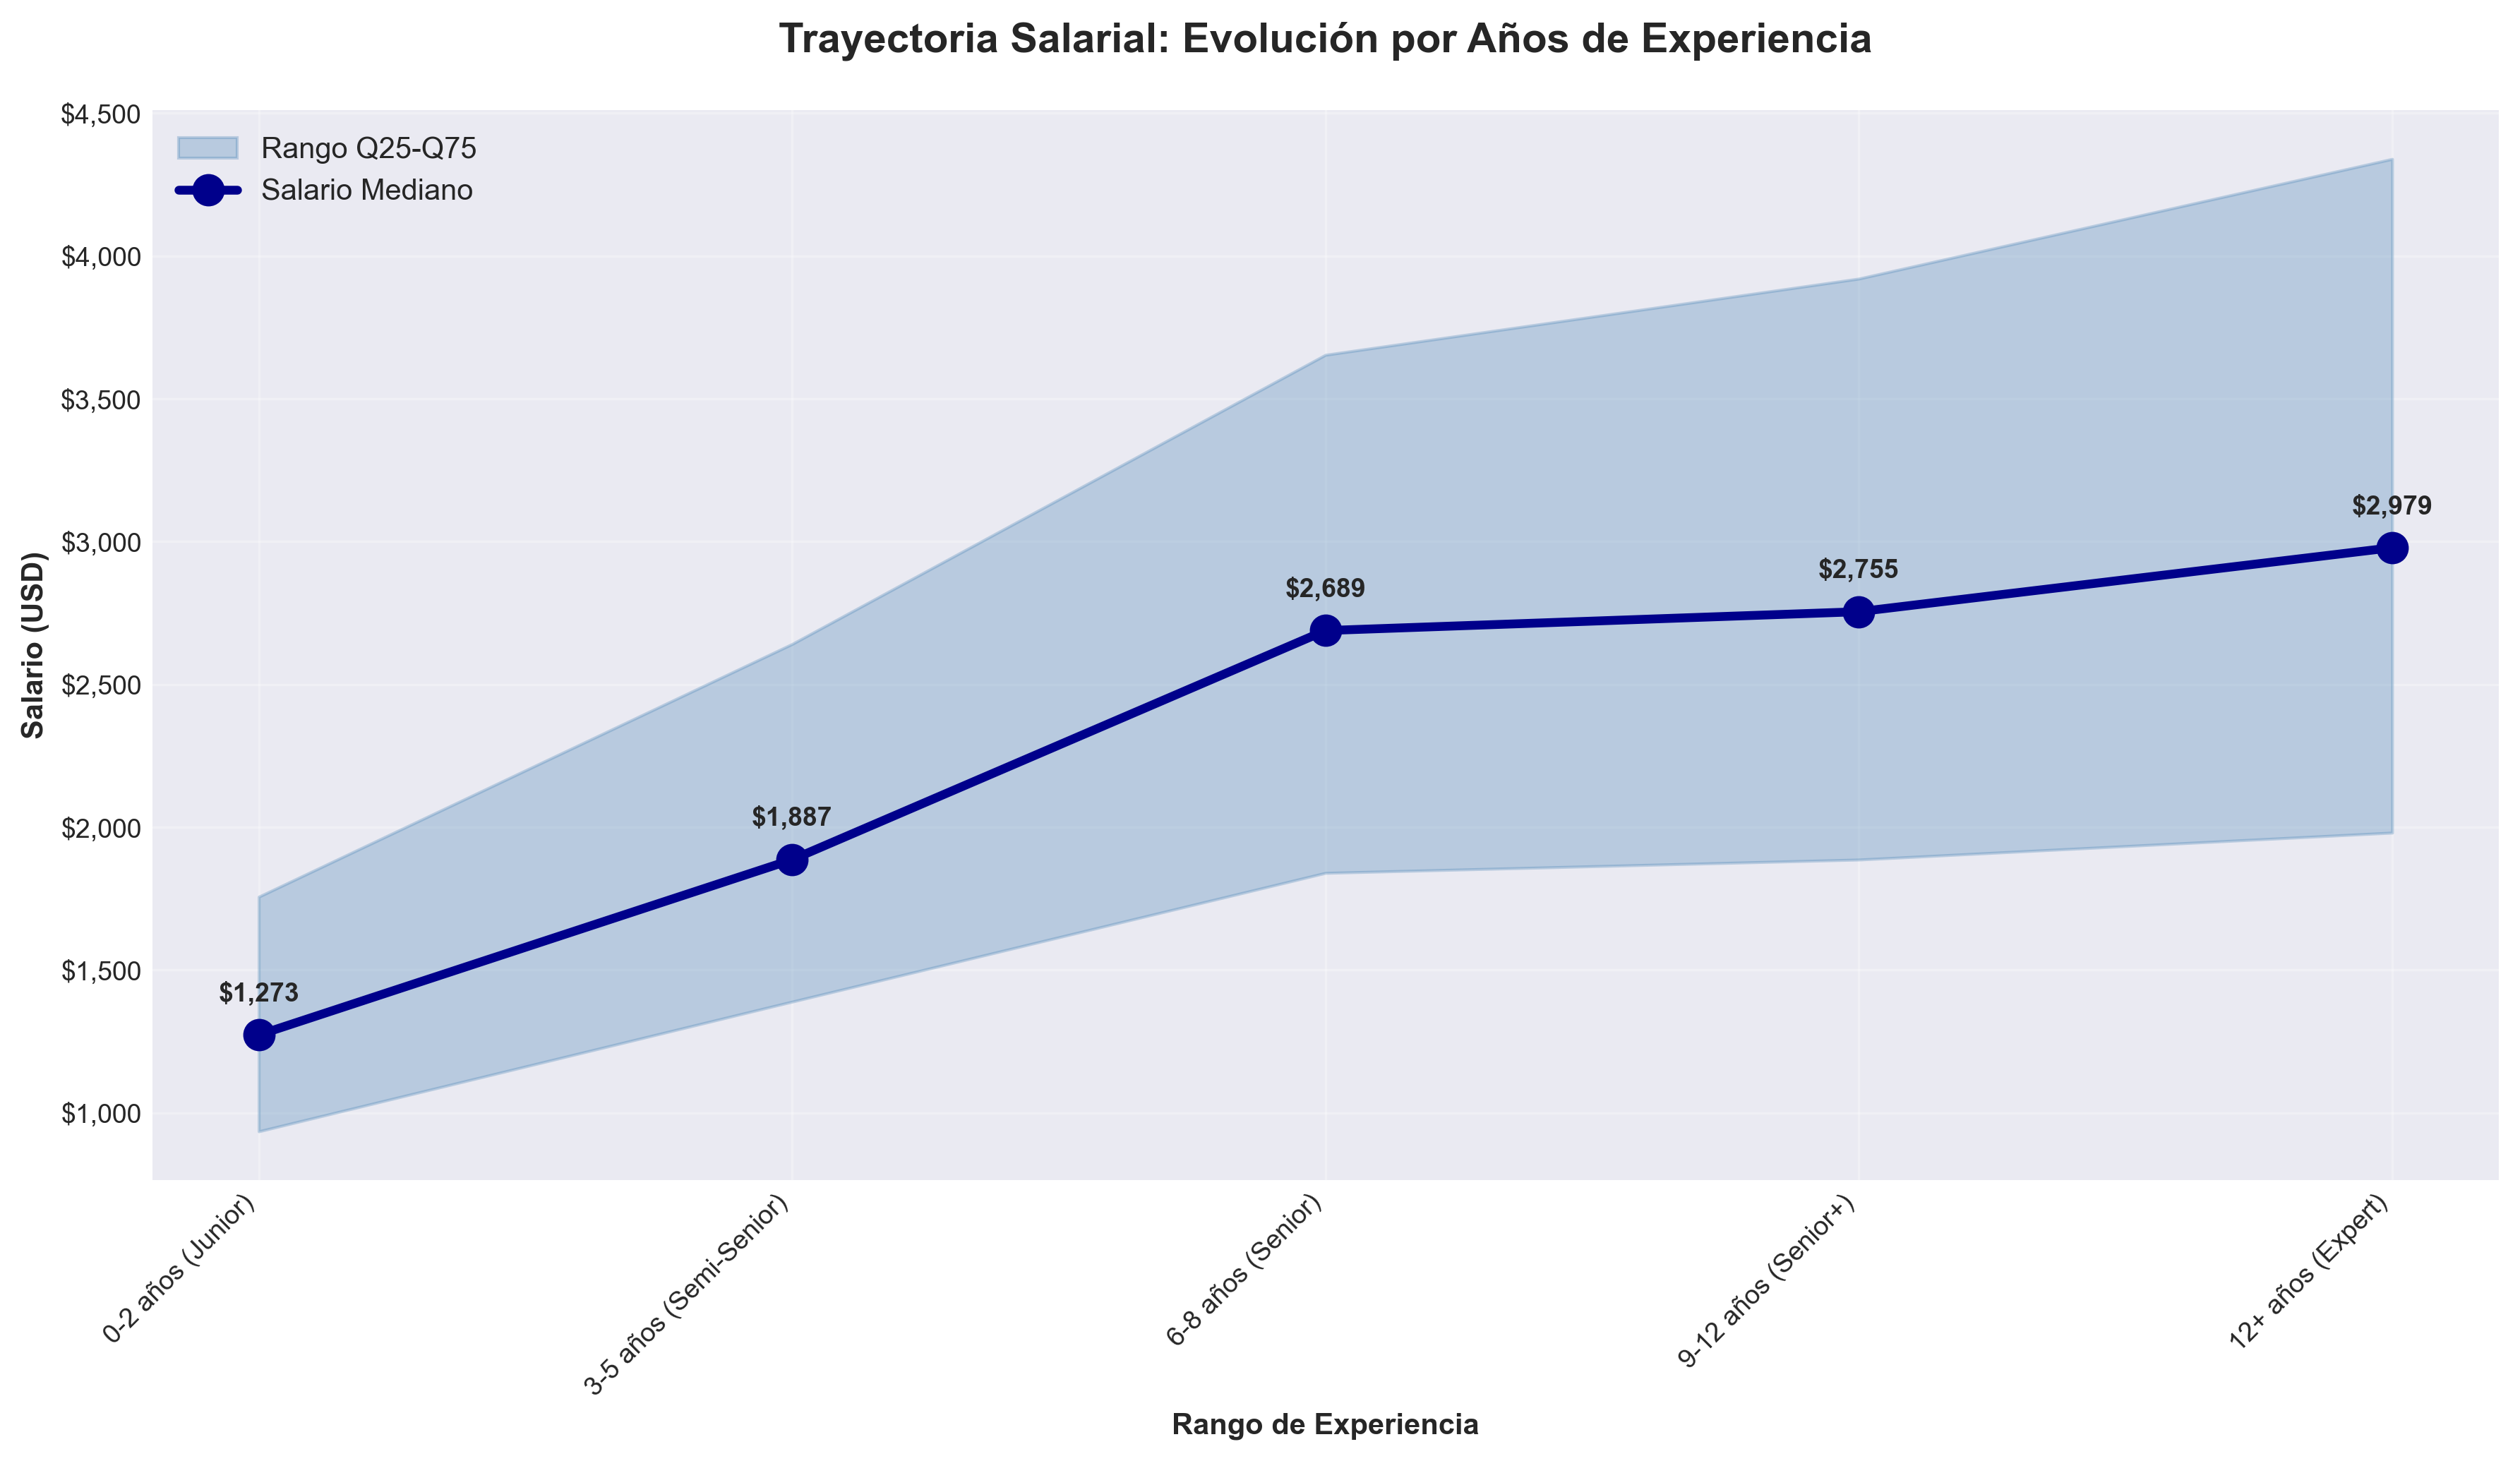

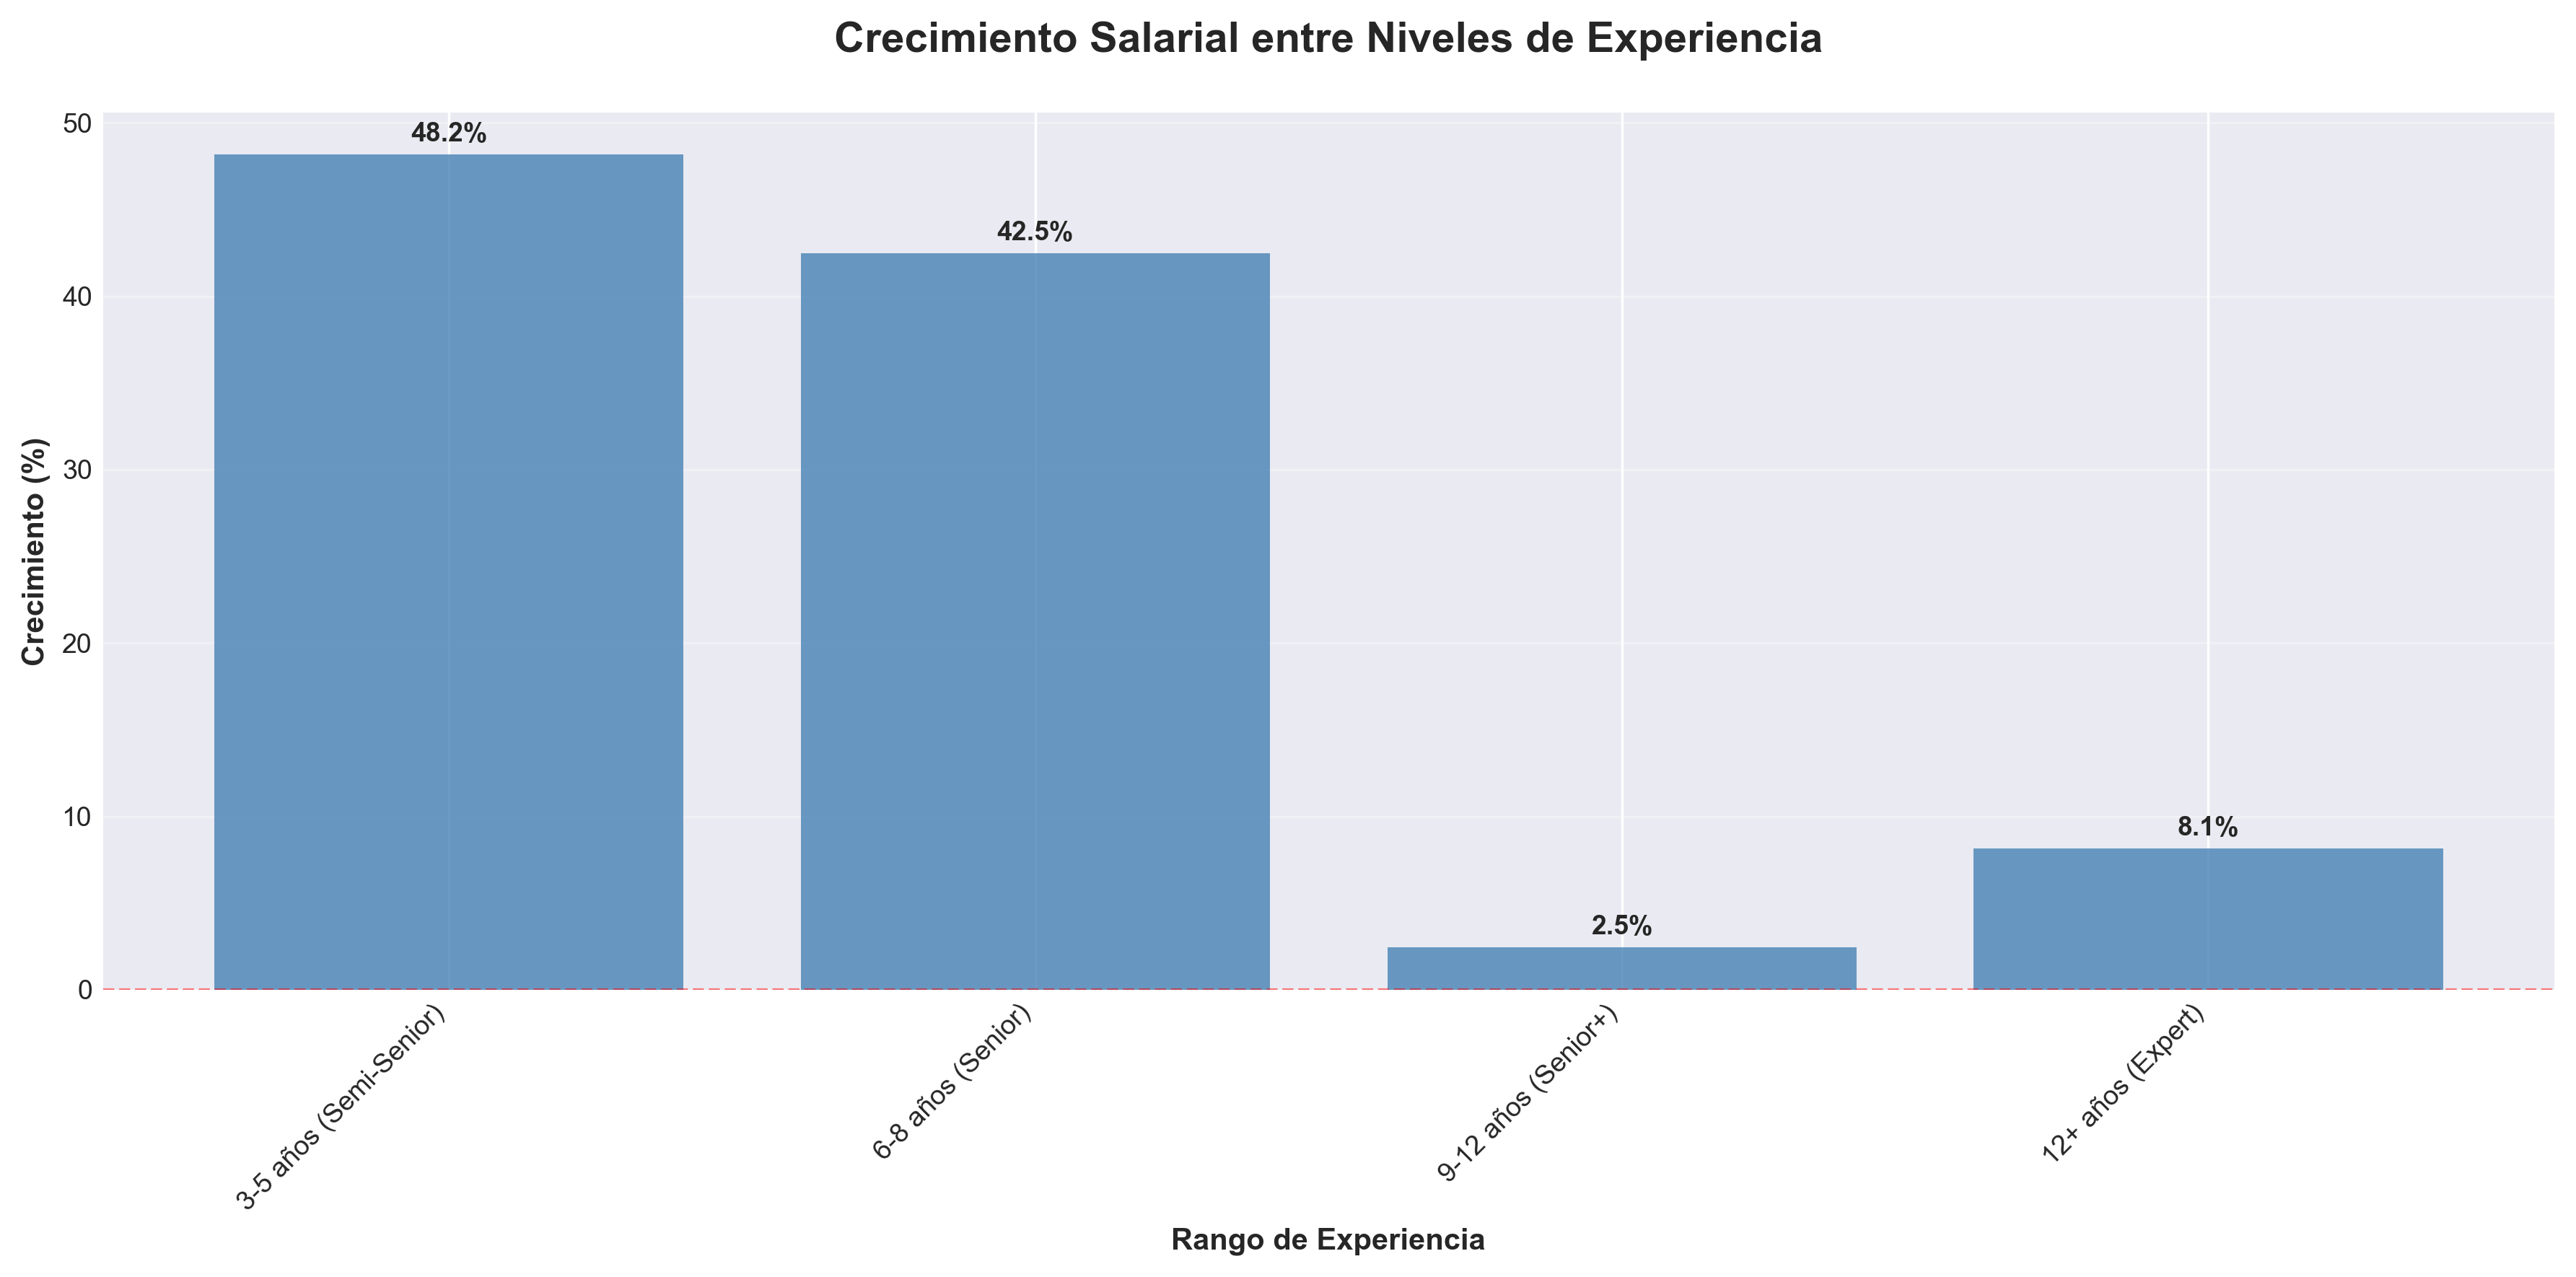

In [8]:
# Visualización: Evolución del salario mediano
fig, ax = plt.subplots(figsize=(12, 7))

x_pos = range(len(trayectoria.index))
x_labels = [str(idx) for idx in trayectoria.index]

# Área de dispersión (Q25-Q75)
ax.fill_between(x_pos, trayectoria['Q25'], trayectoria['Q75'], 
                alpha=0.3, color='steelblue', label='Rango Q25-Q75')

# Línea de mediana
line = ax.plot(x_pos, trayectoria['Mediana'], marker='o', linewidth=3, 
               markersize=10, color='darkblue', label='Salario Mediano')

# Agregar valores en los puntos
for i, (x, y) in enumerate(zip(x_pos, trayectoria['Mediana'])):
    ax.text(x, y + 100, f'${y:,.0f}', ha='center', va='bottom', 
            fontsize=9, fontweight='bold')

ax.set_xticks(x_pos)
ax.set_xticklabels(x_labels, rotation=45, ha='right')
ax.set_xlabel('Rango de Experiencia', fontweight='bold')
ax.set_ylabel('Salario (USD)', fontweight='bold')
ax.set_title('Trayectoria Salarial: Evolución por Años de Experiencia', 
             pad=20, fontweight='bold', fontsize=14)
ax.legend(loc='upper left', framealpha=0.9)
ax.grid(True, alpha=0.3)
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))

plt.tight_layout()
plt.show()

# Gráfico de crecimiento porcentual
fig, ax = plt.subplots(figsize=(12, 6))

# Filtrar valores no nulos
crecimiento_data = trayectoria['Crecimiento_%'].dropna()
x_pos = range(len(crecimiento_data))
x_labels = [str(idx) for idx in crecimiento_data.index]

bars = ax.bar(x_pos, crecimiento_data.values, color='steelblue', alpha=0.8)

# Agregar valores en las barras
for i, (bar, value) in enumerate(zip(bars, crecimiento_data.values)):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
            f'{value:.1f}%', ha='center', va='bottom', fontsize=9, fontweight='bold')

ax.set_xticks(x_pos)
ax.set_xticklabels(x_labels, rotation=45, ha='right')
ax.set_xlabel('Rango de Experiencia', fontweight='bold')
ax.set_ylabel('Crecimiento (%)', fontweight='bold')
ax.set_title('Crecimiento Salarial entre Niveles de Experiencia', 
             pad=20, fontweight='bold', fontsize=14)
ax.grid(axis='y', alpha=0.3)
ax.axhline(y=0, color='red', linestyle='--', linewidth=1, alpha=0.5)

plt.tight_layout()
plt.show()

### Visualizaciones comparativas

Ahora bien, una vez que tenemos toda esta información, podemos intentar combinar las variables para encontrar la combinación ganadora que maximiza el salario.

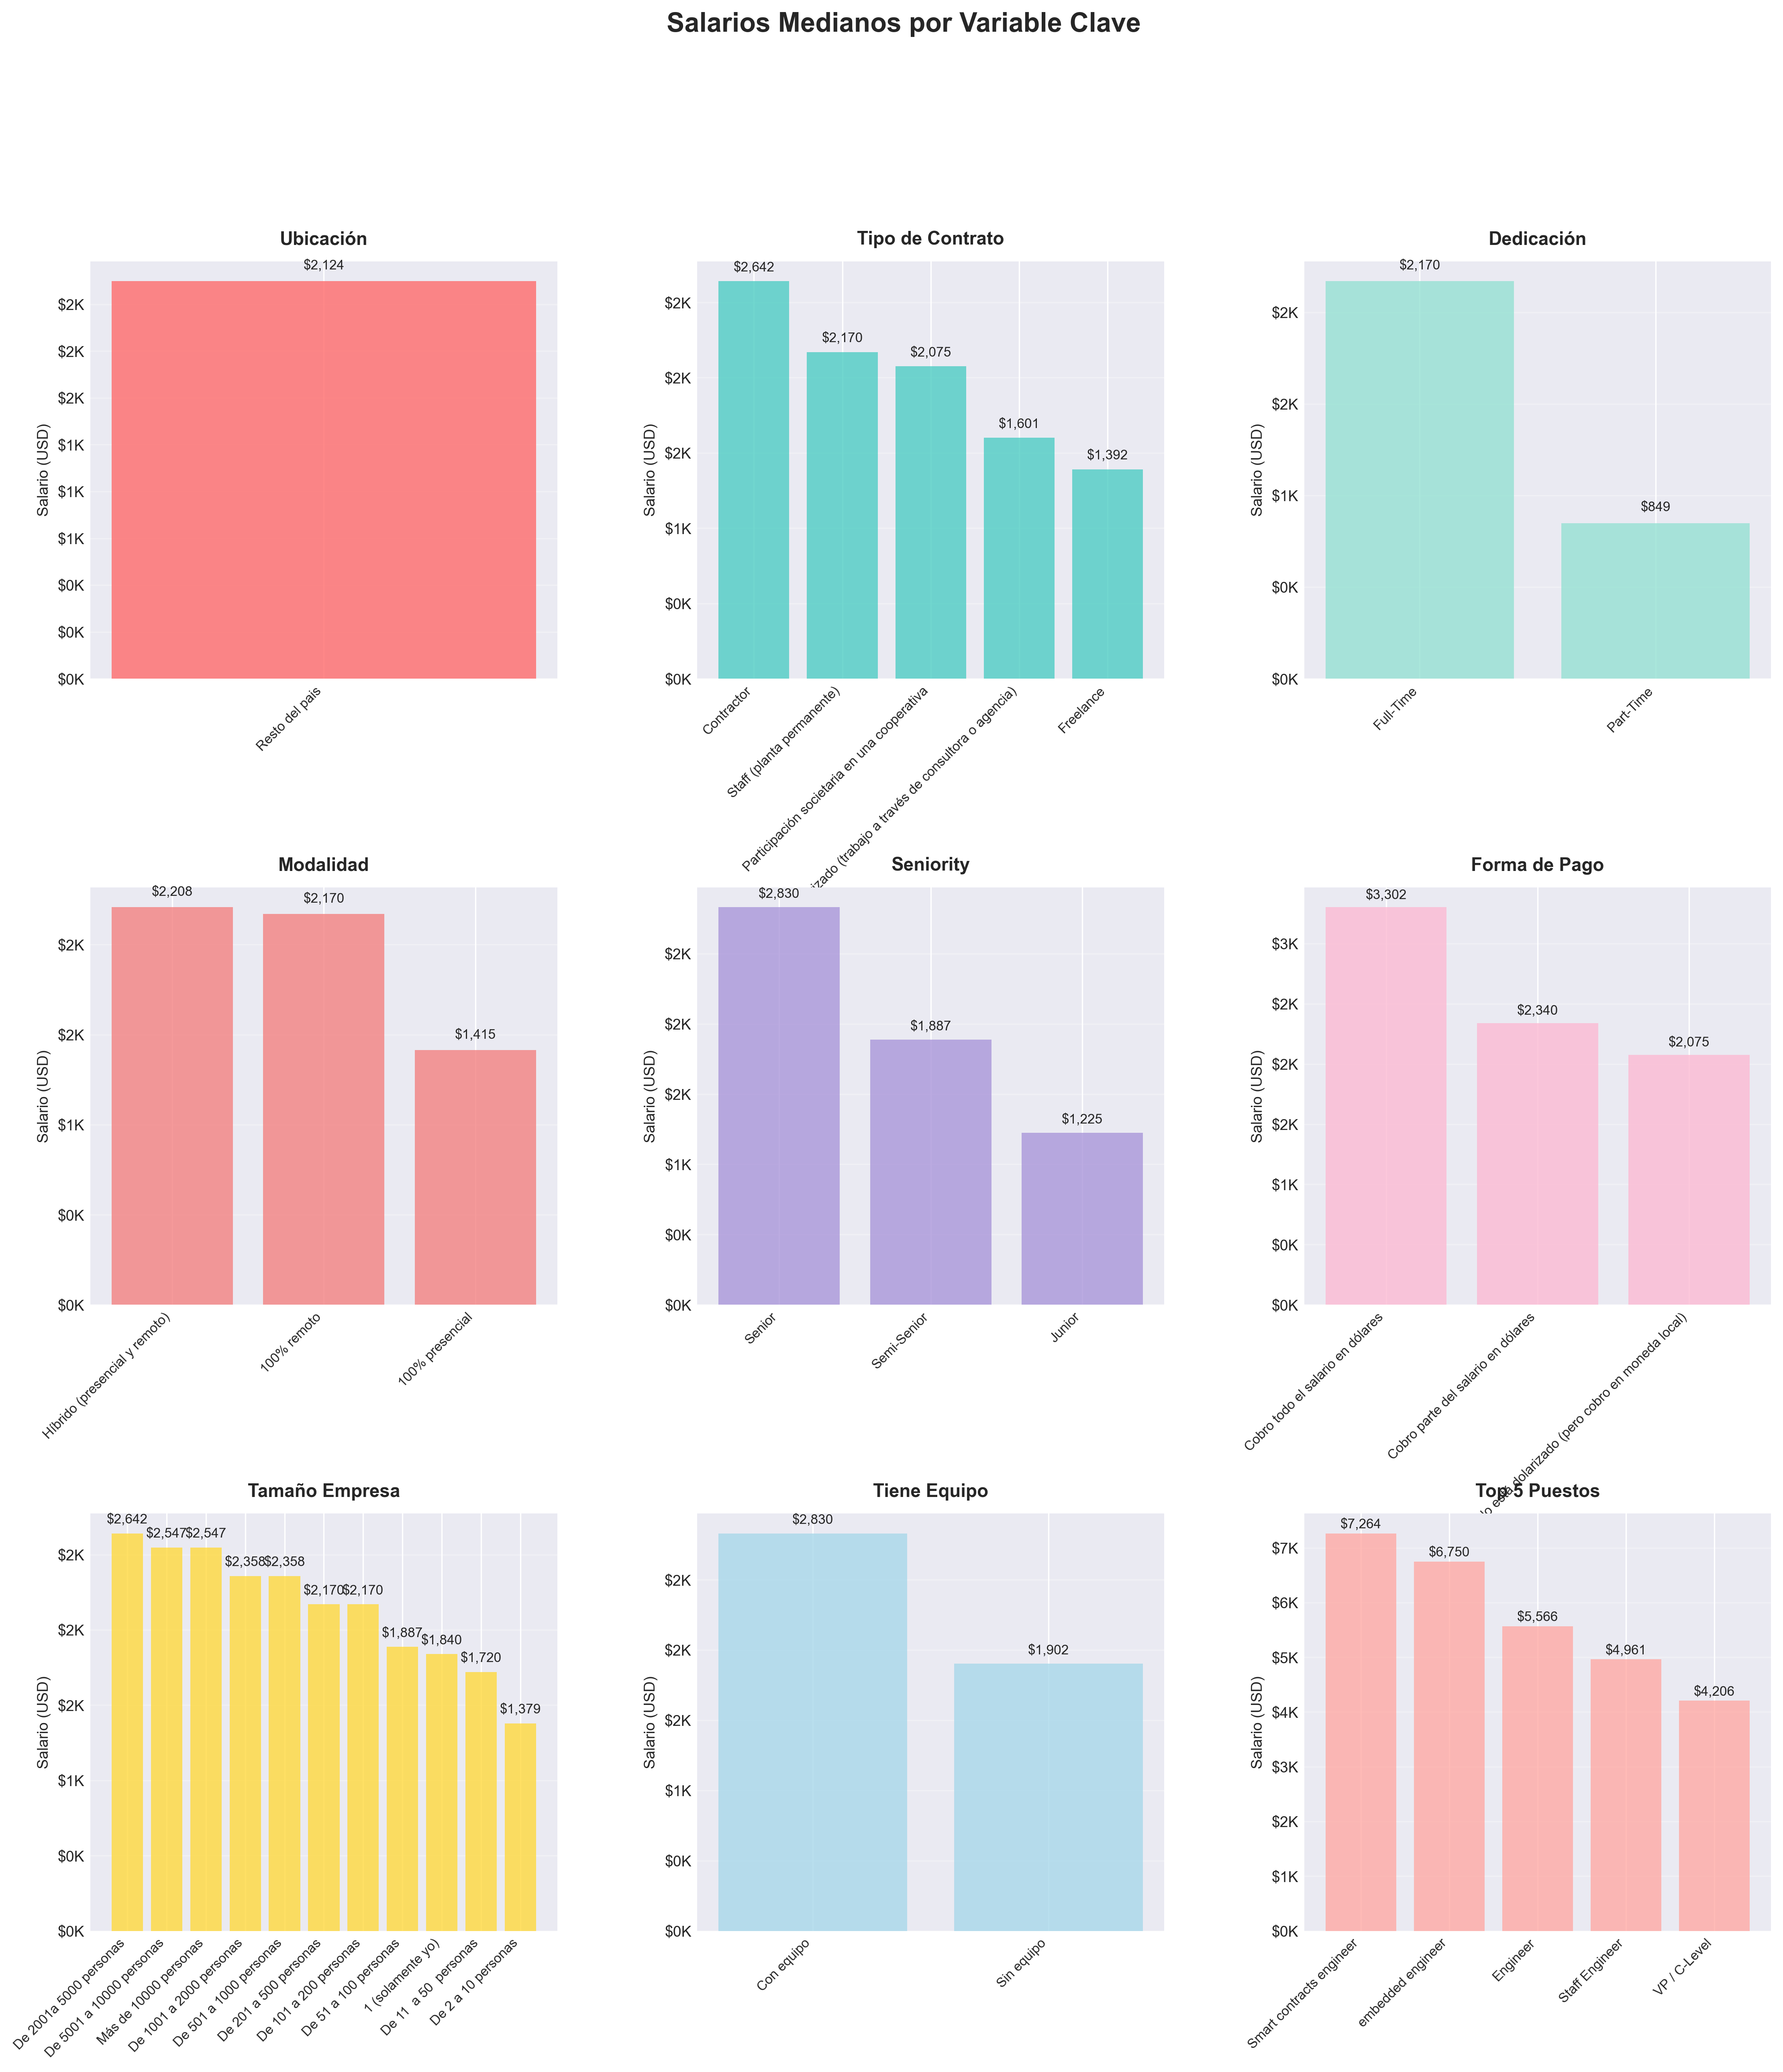


[TOP 10 COMBINACIONES]

Top 10 Combinaciones (Ubicación + Contrato + Dedicación):
                                                                                 Media  \
es_caba        tipo_contrato                                      dedicacion             
Resto del pais Contractor                                         Full-Time   12040.33   
               Staff (planta permanente)                          Full-Time    4563.36   
               Participación societaria en una cooperativa        Full-Time    2268.23   
               Freelance                                          Full-Time    2309.57   
               Tercerizado (trabajo a través de consultora o a... Full-Time    1912.36   
               Staff (planta permanente)                          Part-Time    1343.89   
               Contractor                                         Part-Time    1324.06   
               Tercerizado (trabajo a través de consultora o a... Part-Time     887.62   
               Fr

In [9]:
# Visualización: Salarios Medianos por Variable Clave
fig = plt.figure(figsize=(18, 18))  # Aumenté la altura de 16 a 18
gs = GridSpec(3, 3, figure=fig, hspace=0.5, wspace=0.3)  # Aumenté hspace de 0.4 a 0.5

colors = ['#FF6B6B', '#4ECDC4', '#95E1D3', '#F38181', '#AA96DA', 
          '#FCBAD3', '#FFD93D', '#A8D8EA', '#FFAAA5']

datasets = [
    (ubicacion_stats, 'Ubicación', 0, 0),
    (contrato_stats, 'Tipo de Contrato', 0, 1),
    (dedicacion_stats, 'Dedicación', 0, 2),
    (modalidad_stats, 'Modalidad', 1, 0),
    (seniority_stats, 'Seniority', 1, 1),
    (pago_stats, 'Forma de Pago', 1, 2),
    (empresa_stats, 'Tamaño Empresa', 2, 0),
    (equipo_stats, 'Tiene Equipo', 2, 1),
    (puesto_stats.head(5), 'Top 5 Puestos', 2, 2)
]

for idx, (data, title, row, col) in enumerate(datasets):
    ax = fig.add_subplot(gs[row, col])
    
    x_pos = range(len(data.index))
    bars = ax.bar(x_pos, data['Mediana'], color=colors[idx], alpha=0.8)
    
    # Valores en las barras
    for i, (bar, value) in enumerate(zip(bars, data['Mediana'])):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50, 
                f'${value:,.0f}', ha='center', va='bottom', fontsize=8)
    
    ax.set_xticks(x_pos)
    ax.set_xticklabels(data.index, rotation=45, ha='right', fontsize=8)
    ax.set_title(title, fontweight='bold', fontsize=11, pad=10)
    ax.set_ylabel('Salario (USD)', fontsize=9)
    ax.grid(axis='y', alpha=0.3)
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1000:.0f}K'))

fig.suptitle('Salarios Medianos por Variable Clave', 
             fontsize=16, fontweight='bold', y=0.995)

plt.tight_layout(rect=[0, 0, 1, 0.99])  # Añadí esto para ajustar mejor el layout
plt.show()

# Top 10 combinaciones
print("\n[TOP 10 COMBINACIONES]\n")
print("Top 10 Combinaciones (Ubicación + Contrato + Dedicación):")
combinaciones = df_analisis.groupby(['es_caba', 'tipo_contrato', 'dedicacion'])['salario_usd'].agg([
    ('Media', 'mean'),
    ('Mediana', 'median'),
    ('Cantidad', 'count')
]).round(2)

combinaciones_filtradas = combinaciones[combinaciones['Cantidad'] >= 3].sort_values('Mediana', ascending=False).head(10)
print(combinaciones_filtradas)
print()

### La combinación ganadora

Después de todo este análisis, podemos finalmente presentar la combinación ganadora que maximiza el salario. Esta combinación se basa en las variables que hemos analizado y las conclusiones que hemos extraído a lo largo de este "análisis exploratorio de datos" (EDA).

In [10]:
resumen = f"""
PERFIL DE LOS TRABAJADORES MEJOR PAGOS

[1] UBICACION: {mejor_ubicacion}
    Mediana: ${ubicacion_stats.loc[mejor_ubicacion, 'Mediana']:,.0f} USD

[2] TIPO CONTRATO: {mejor_contrato}
    Mediana: ${contrato_stats.loc[mejor_contrato, 'Mediana']:,.0f} USD

[3] DEDICACION: {mejor_dedicacion}
    Mediana: ${dedicacion_stats.loc[mejor_dedicacion, 'Mediana']:,.0f} USD

[4] MODALIDAD: {mejor_modalidad}
    Mediana: ${modalidad_stats.loc[mejor_modalidad, 'Mediana']:,.0f} USD

[5] SENIORITY: {mejor_seniority}
    Mediana: ${seniority_stats.loc[mejor_seniority, 'Mediana']:,.0f} USD

[6] PUESTO: {mejor_puesto}
    Mediana: ${puesto_stats.loc[mejor_puesto, 'Mediana']:,.0f} USD

[7] FORMA PAGO: {mejor_pago}
    Mediana: ${pago_stats.loc[mejor_pago, 'Mediana']:,.0f} USD

[8] TAMANO EMPRESA: {mejor_empresa}
    Mediana: ${empresa_stats.loc[mejor_empresa, 'Mediana']:,.0f} USD

[9] LIDERAZGO: {mejor_equipo}
    Mediana: ${equipo_stats.loc[mejor_equipo, 'Mediana']:,.0f} USD

EVOLUCION ESPERADA DEL SALARIO

0-2 años:  ${trayectoria.iloc[0]['Mediana']:,.0f} USD
3-5 años:  ${trayectoria.iloc[1]['Mediana']:,.0f} USD (+{trayectoria.iloc[1]['Crecimiento_%']:.1f}%)
6-8 años:  ${trayectoria.iloc[2]['Mediana']:,.0f} USD (+{trayectoria.iloc[2]['Crecimiento_%']:.1f}%)
9-12 años: ${trayectoria.iloc[3]['Mediana']:,.0f} USD (+{trayectoria.iloc[3]['Crecimiento_%']:.1f}%)
12+ años:  ${trayectoria.iloc[4]['Mediana']:,.0f} USD (+{trayectoria.iloc[4]['Crecimiento_%']:.1f}%)

RECOMENDACIONES PARA MAXIMIZAR SALARIO

1. Ubicarse en {mejor_ubicacion}
2. Buscar contratos tipo {mejor_contrato}
3. Trabajar {mejor_dedicacion}
4. Priorizar modalidad {mejor_modalidad}
5. Desarrollarse hasta {mejor_seniority}
6. Especializarse en roles como {mejor_puesto}
7. Negociar modalidad "{mejor_pago}"
8. Apuntar a empresas {mejor_empresa}
9. Desarrollar capacidad de liderazgo ({mejor_equipo})
10. Acumular ~{top_10_percent['experiencia'].mean():.0f} años de experiencia

Objetivo: Alcanzar Top 10% (${percentil_90:,.0f}+ USD/mes)
"""

print(resumen)


PERFIL DE LOS TRABAJADORES MEJOR PAGOS

[1] UBICACION: Resto del pais
    Mediana: $2,124 USD

[2] TIPO CONTRATO: Contractor
    Mediana: $2,642 USD

[3] DEDICACION: Full-Time
    Mediana: $2,170 USD

[4] MODALIDAD: Híbrido (presencial y remoto)
    Mediana: $2,208 USD

[5] SENIORITY: Senior
    Mediana: $2,830 USD

[6] PUESTO: Smart contracts engineer
    Mediana: $7,264 USD

[7] FORMA PAGO: Cobro todo el salario en dólares
    Mediana: $3,302 USD

[8] TAMANO EMPRESA: De 2001a 5000 personas
    Mediana: $2,642 USD

[9] LIDERAZGO: Con equipo
    Mediana: $2,830 USD

EVOLUCION ESPERADA DEL SALARIO

0-2 años:  $1,273 USD
3-5 años:  $1,887 USD (+48.2%)
6-8 años:  $2,689 USD (+42.5%)
9-12 años: $2,755 USD (+2.5%)
12+ años:  $2,979 USD (+8.1%)

RECOMENDACIONES PARA MAXIMIZAR SALARIO

1. Ubicarse en Resto del pais
2. Buscar contratos tipo Contractor
3. Trabajar Full-Time
4. Priorizar modalidad Híbrido (presencial y remoto)
5. Desarrollarse hasta Senior
6. Especializarse en roles como Smart 

## Machine Learning: _Random Forest Regressor_

En esta parte del trabajo, buscamos ir más allá del análisis descriptivo y explorar la importancia relativa de las variables en la predicción del salario utilizando técnicas de Machine Learning. Nuestro objetivo es identificar cuáles son las características más influyentes que determinan el salario de los profesionales en el sector IT y ver si existe una coincidencia entre estas variables y las que hemos identificado en nuestro análisis previo como parte de la "combinación ganadora". Creemos que al sumar este enfoque, podemos obtener una visión más completa y robusta de los factores que impactan en el salario, validando o complementando nuestras conclusiones anteriores con un análisis basado en datos y modelos predictivos.

### Importancia de las variables

En primer lugar, debemos preparar los datos para el modelo de Machine Learning. Esto incluye seleccionar las variables relevantes, manejar valores faltantes y dividir los datos en conjuntos de entrenamiento y prueba. El modelo que vamos a aplicar es un Random Forest Regressor, muy utilizado para problemas de regresión que puede manejar tanto variables numéricas como categóricas.

[INFO] Categorias de puestos creadas
puesto_categoria
Developer             1776
Management             843
Infra/Ops/Security     720
Data & Analytics       567
Other                  433
UX/UI Design           264
QA / Testing           247
Consultant             155
Architect              125
Product                 33
Agile / Scrum           33
Name: count, dtype: int64



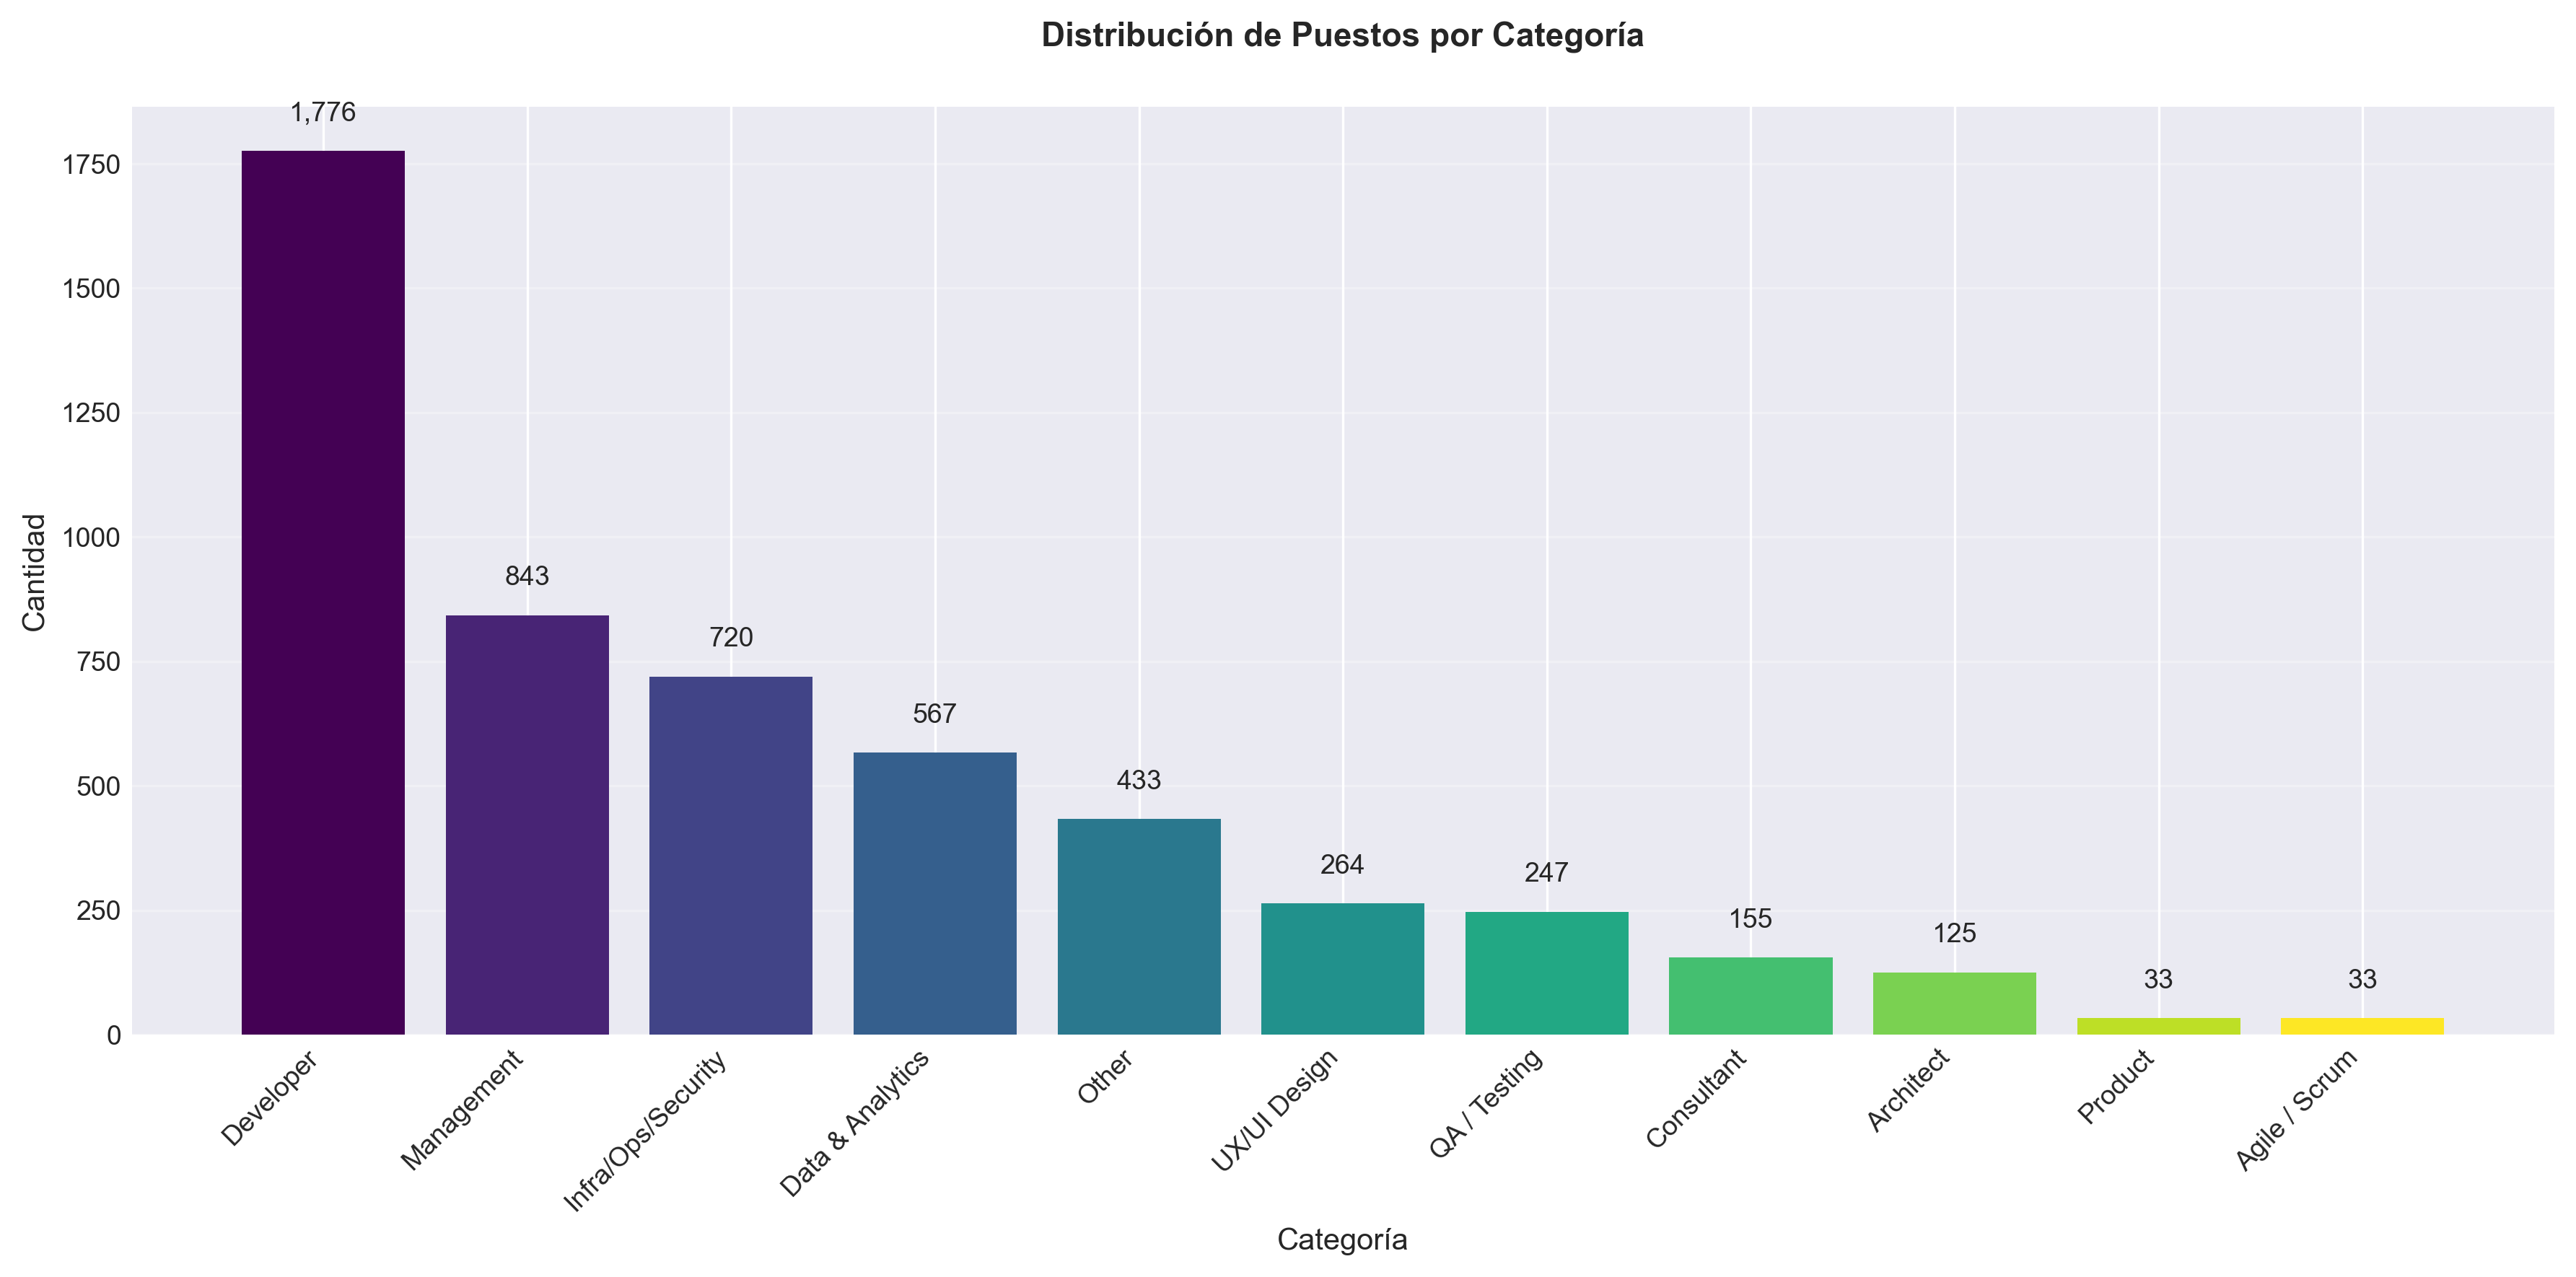

[INFO] Tamaño empresa simplificado:
tamano_empresa
Pequeña (1-100)       1917
Mediana (101-1000)    1718
Grande (1000+)        1561
Name: count, dtype: int64

[INFO] Registros iniciales: 1848

[LIMPIEZA DE DATOS]
Después de eliminar infinitos: 1848 registros
Después de eliminar salarios <= 0: 1848 registros
Rango válido: $259 - $12,198 USD
Después de filtrar outliers extremos: 1828 registros
Después de validar rangos de variables: 1827 registros

[INFO] Registros finales para modelo: 1827
[INFO] Variables predictoras: 11
[INFO] Salario USD - Min: $261 | Max: $12,106
[INFO] Salario USD - Media: $3,126 | Mediana: $2,642

[INFO] Features después de encoding: 26
[VALIDACIÓN] NaN en X: 0
[VALIDACIÓN] Infinitos en X: 0
[VALIDACIÓN] NaN en y: 0
[VALIDACIÓN] Infinitos en y: 0

[MODELO] Entrenamiento: 1461 | Test: 366
[MODELO] Entrenado exitosamente

MÉTRICAS DEL MODELO
MAE Train: $1,129 USD
MAE Test:  $1,097 USD
RMSE Test: $1,559 USD
R² Train:  0.4104 (41.04%)
R² Test:   0.3647 (36.47%)

El mo

R² promedio: 0.3445 (±0.0251)
R² por fold: ['0.371', '0.369', '0.340', '0.341', '0.301']


MAE promedio: $1,177 (±$56)



In [11]:
# Categorizar puestos
def categorizar_puesto(puesto):
    if pd.isna(puesto):
        return 'Other'
    puesto = str(puesto).lower()
    if re.search(r'developer|desarrollador|programador|frontend|backend|fullstack|mobile|web|software engineer', puesto):
        return 'Developer'
    if re.search(r'data|bi |business intelligence|analytics|analista de datos|machine learning|ciencia de datos|scientist', puesto):
        return 'Data & Analytics'
    if re.search(r'manager|management|lider|leader|director|gerente|vp|c-level|head|ceo|cto|cio', puesto):
        return 'Management'
    if re.search(r'devops|sysadmin|infraestructura|infrastructure|sre|networking|cloud|seguridad|security|systems', puesto):
        return 'Infra/Ops/Security'
    if re.search(r'qa|testing|tester|automation|quality', puesto):
        return 'QA / Testing'
    if re.search(r'product|pm|po|product owner|product manager', puesto):
        return 'Product'
    if re.search(r'scrum|agile|coach', puesto):
        return 'Agile / Scrum'
    if re.search(r'ux|ui|designer|disenador|design', puesto):
        return 'UX/UI Design'
    if re.search(r'architect|arquitecto', puesto):
        return 'Architect'
    if re.search(r'consultor|consultant|functional|specialist', puesto):
        return 'Consultant'
    return 'Other'

df_clean['puesto_categoria'] = df_clean['puesto'].apply(categorizar_puesto)

print("[INFO] Categorias de puestos creadas")
print(df_clean['puesto_categoria'].value_counts())
print()

# Visualización: Distribución de categorías de puestos
puesto_cat_counts = df_clean['puesto_categoria'].value_counts()

fig, ax = plt.subplots(figsize=(12, 6))
bars = ax.bar(range(len(puesto_cat_counts)), puesto_cat_counts.values, 
              color=plt.cm.viridis(np.linspace(0, 1, len(puesto_cat_counts))))

ax.set_xticks(range(len(puesto_cat_counts)))
ax.set_xticklabels(puesto_cat_counts.index, rotation=45, ha='right')
ax.set_xlabel('Categoría')
ax.set_ylabel('Cantidad')
ax.set_title('Distribución de Puestos por Categoría', pad=20, fontweight='bold')
ax.grid(axis='y', alpha=0.3)

# Agregar valores en las barras
for i, (bar, value) in enumerate(zip(bars, puesto_cat_counts.values)):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50, 
            f'{value:,}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

# Simplificar tamaño de empresa
def simplificar_tamano_empresa(tamano):
    if pd.isna(tamano):
        return 'Desconocido'
    if any(x in str(tamano) for x in ['De 2 a', 'De 11', 'De 51', '1 (solamente']):
        return 'Pequeña (1-100)'
    elif any(x in str(tamano) for x in ['De 101', 'De 201', 'De 501']):
        return 'Mediana (101-1000)'
    else:
        return 'Grande (1000+)'

# Aplicar la simplificación al dataframe original
df_clean['tamano_empresa'] = df_clean['tamano_empresa'].apply(simplificar_tamano_empresa)
print(f"[INFO] Tamaño empresa simplificado:")
print(df_clean['tamano_empresa'].value_counts())
print()

# Preparar datos para modelo
features_list = ['experiencia', 'antiguedad', 'edad', 'seniority', 'modalidad',
                 'es_caba', 'tipo_contrato', 'tamano_empresa', 'puesto_categoria',
                 'forma_pago', 'tiene_equipo']

features_list = [col for col in features_list if col in df_clean.columns]
df_model = df_clean[features_list + ['salario_usd']].dropna()

print(f"[INFO] Registros iniciales: {len(df_model)}")

# Eliminación de outliers extremos y valores inválidos
print("\n[LIMPIEZA DE DATOS]")

# 1. Eliminar infinitos y NaN remanentes
df_model = df_model.replace([np.inf, -np.inf], np.nan).dropna()
print(f"Después de eliminar infinitos: {len(df_model)} registros")

# 2. Eliminar salarios negativos o cero
df_model = df_model[df_model['salario_usd'] > 0]
print(f"Después de eliminar salarios <= 0: {len(df_model)} registros")

# 3. Filtrar outliers usando IQR (rango intercuartílico)
Q1 = df_model['salario_usd'].quantile(0.005)  # Percentil 0.5
Q99 = df_model['salario_usd'].quantile(0.995)  # Percentil 99.5 

print(f"Rango válido: ${Q1:,.0f} - ${Q99:,.0f} USD")

df_model = df_model[(df_model['salario_usd'] >= Q1) & (df_model['salario_usd'] <= Q99)]
print(f"Después de filtrar outliers extremos: {len(df_model)} registros")

# 4. Verificar rangos razonables en otras variables
df_model = df_model[
    (df_model['experiencia'] >= 0) & (df_model['experiencia'] <= 50) &
    (df_model['edad'] >= 18) & (df_model['edad'] <= 80) &
    (df_model['antiguedad'] >= 0) & (df_model['antiguedad'] <= 50)
]
print(f"Después de validar rangos de variables: {len(df_model)} registros")

print(f"\n[INFO] Registros finales para modelo: {len(df_model)}")
print(f"[INFO] Variables predictoras: {len(features_list)}")
print(f"[INFO] Salario USD - Min: ${df_model['salario_usd'].min():,.0f} | Max: ${df_model['salario_usd'].max():,.0f}")
print(f"[INFO] Salario USD - Media: ${df_model['salario_usd'].mean():,.0f} | Mediana: ${df_model['salario_usd'].median():,.0f}\n")

# Encoding
X = pd.get_dummies(df_model[features_list], drop_first=True)
y = df_model['salario_usd']
feature_names = X.columns.tolist()

print(f"[INFO] Features después de encoding: {len(feature_names)}")

# Asegurar que todas las columnas sean numéricas
X = X.apply(pd.to_numeric, errors='coerce')

# Verificar que no haya infinitos o NaN en X o y
nan_count_x = X.isna().sum().sum()
print(f"[VALIDACIÓN] NaN en X: {nan_count_x}")

if nan_count_x > 0:
    print(f"Eliminando {nan_count_x} valores NaN generados en encoding...")
    X = X.fillna(0)  # Rellenar NaN con 0 (seguro para variables dummy)

# Verificar infinitos solo en columnas numéricas
try:
    inf_count_x = np.isinf(X.select_dtypes(include=[np.number]).values).sum()
    print(f"[VALIDACIÓN] Infinitos en X: {inf_count_x}")
except:
    print(f"[VALIDACIÓN] Infinitos en X: 0 (no se pudo verificar)")

print(f"[VALIDACIÓN] NaN en y: {y.isna().sum()}")
print(f"[VALIDACIÓN] Infinitos en y: {np.isinf(y.values).sum()}\n")

# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"[MODELO] Entrenamiento: {len(X_train)} | Test: {len(X_test)}")

# Entrenar
model = RandomForestRegressor(
    n_estimators=50,           
    max_depth=8,               
    min_samples_split=20,      
    min_samples_leaf=10,       
    max_features='sqrt',       
    max_samples=0.8,           
    random_state=42,
    n_jobs=1  # <-- CAMBIAR DE -1 A 1
)
model.fit(X_train, y_train)
print("[MODELO] Entrenado exitosamente\n")

# Métricas
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

mae_train = mean_absolute_error(y_train, y_pred_train)
mae_test = mean_absolute_error(y_test, y_pred_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)

print("MÉTRICAS DEL MODELO")
print(f"MAE Train: ${mae_train:,.0f} USD")
print(f"MAE Test:  ${mae_test:,.0f} USD")
print(f"RMSE Test: ${rmse_test:,.0f} USD")
print(f"R² Train:  {r2_train:.4f} ({r2_train*100:.2f}%)")
print(f"R² Test:   {r2_test:.4f} ({r2_test*100:.2f}%)")

# Verificar overfitting
diff_r2 = r2_train - r2_test
if diff_r2 > 0.1:
    print(f"\nAdvertencia: Posible overfitting (diferencia R²: {diff_r2:.3f})")
else:
    print(f"\nEl modelo generaliza bien (diferencia R²: {diff_r2:.3f})")
print()

print("VALIDACIÓN CRUZADA (5-FOLD):")
cv_scores = cross_val_score(model, X, y, cv=5, scoring='r2', n_jobs=1)  # <-- CAMBIAR DE -1 A 1
print(f"R² promedio: {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")
print(f"R² por fold: {[f'{score:.3f}' for score in cv_scores]}")

# Evaluar también MAE con validación cruzada
cv_mae = -cross_val_score(model, X, y, cv=5, scoring='neg_mean_absolute_error', n_jobs=1)  # <-- CAMBIAR DE -1 A 1
print(f"MAE promedio: ${cv_mae.mean():,.0f} (±${cv_mae.std():,.0f})")
print()

### Visualización: predicciones vs. realidad

El modelo entrenado nos permite hacer predicciones sobre los salarios basándonos en las características de los profesionales. Para evaluar el rendimiento del modelo, podemos comparar las predicciones con los valores reales de salario en el conjunto de prueba. Una forma efectiva de visualizar esta comparación es mediante un gráfico de dispersión (scatter plot), donde cada punto representa un profesional, con su salario real en el eje Y y su salario predicho por el modelo en el eje X.

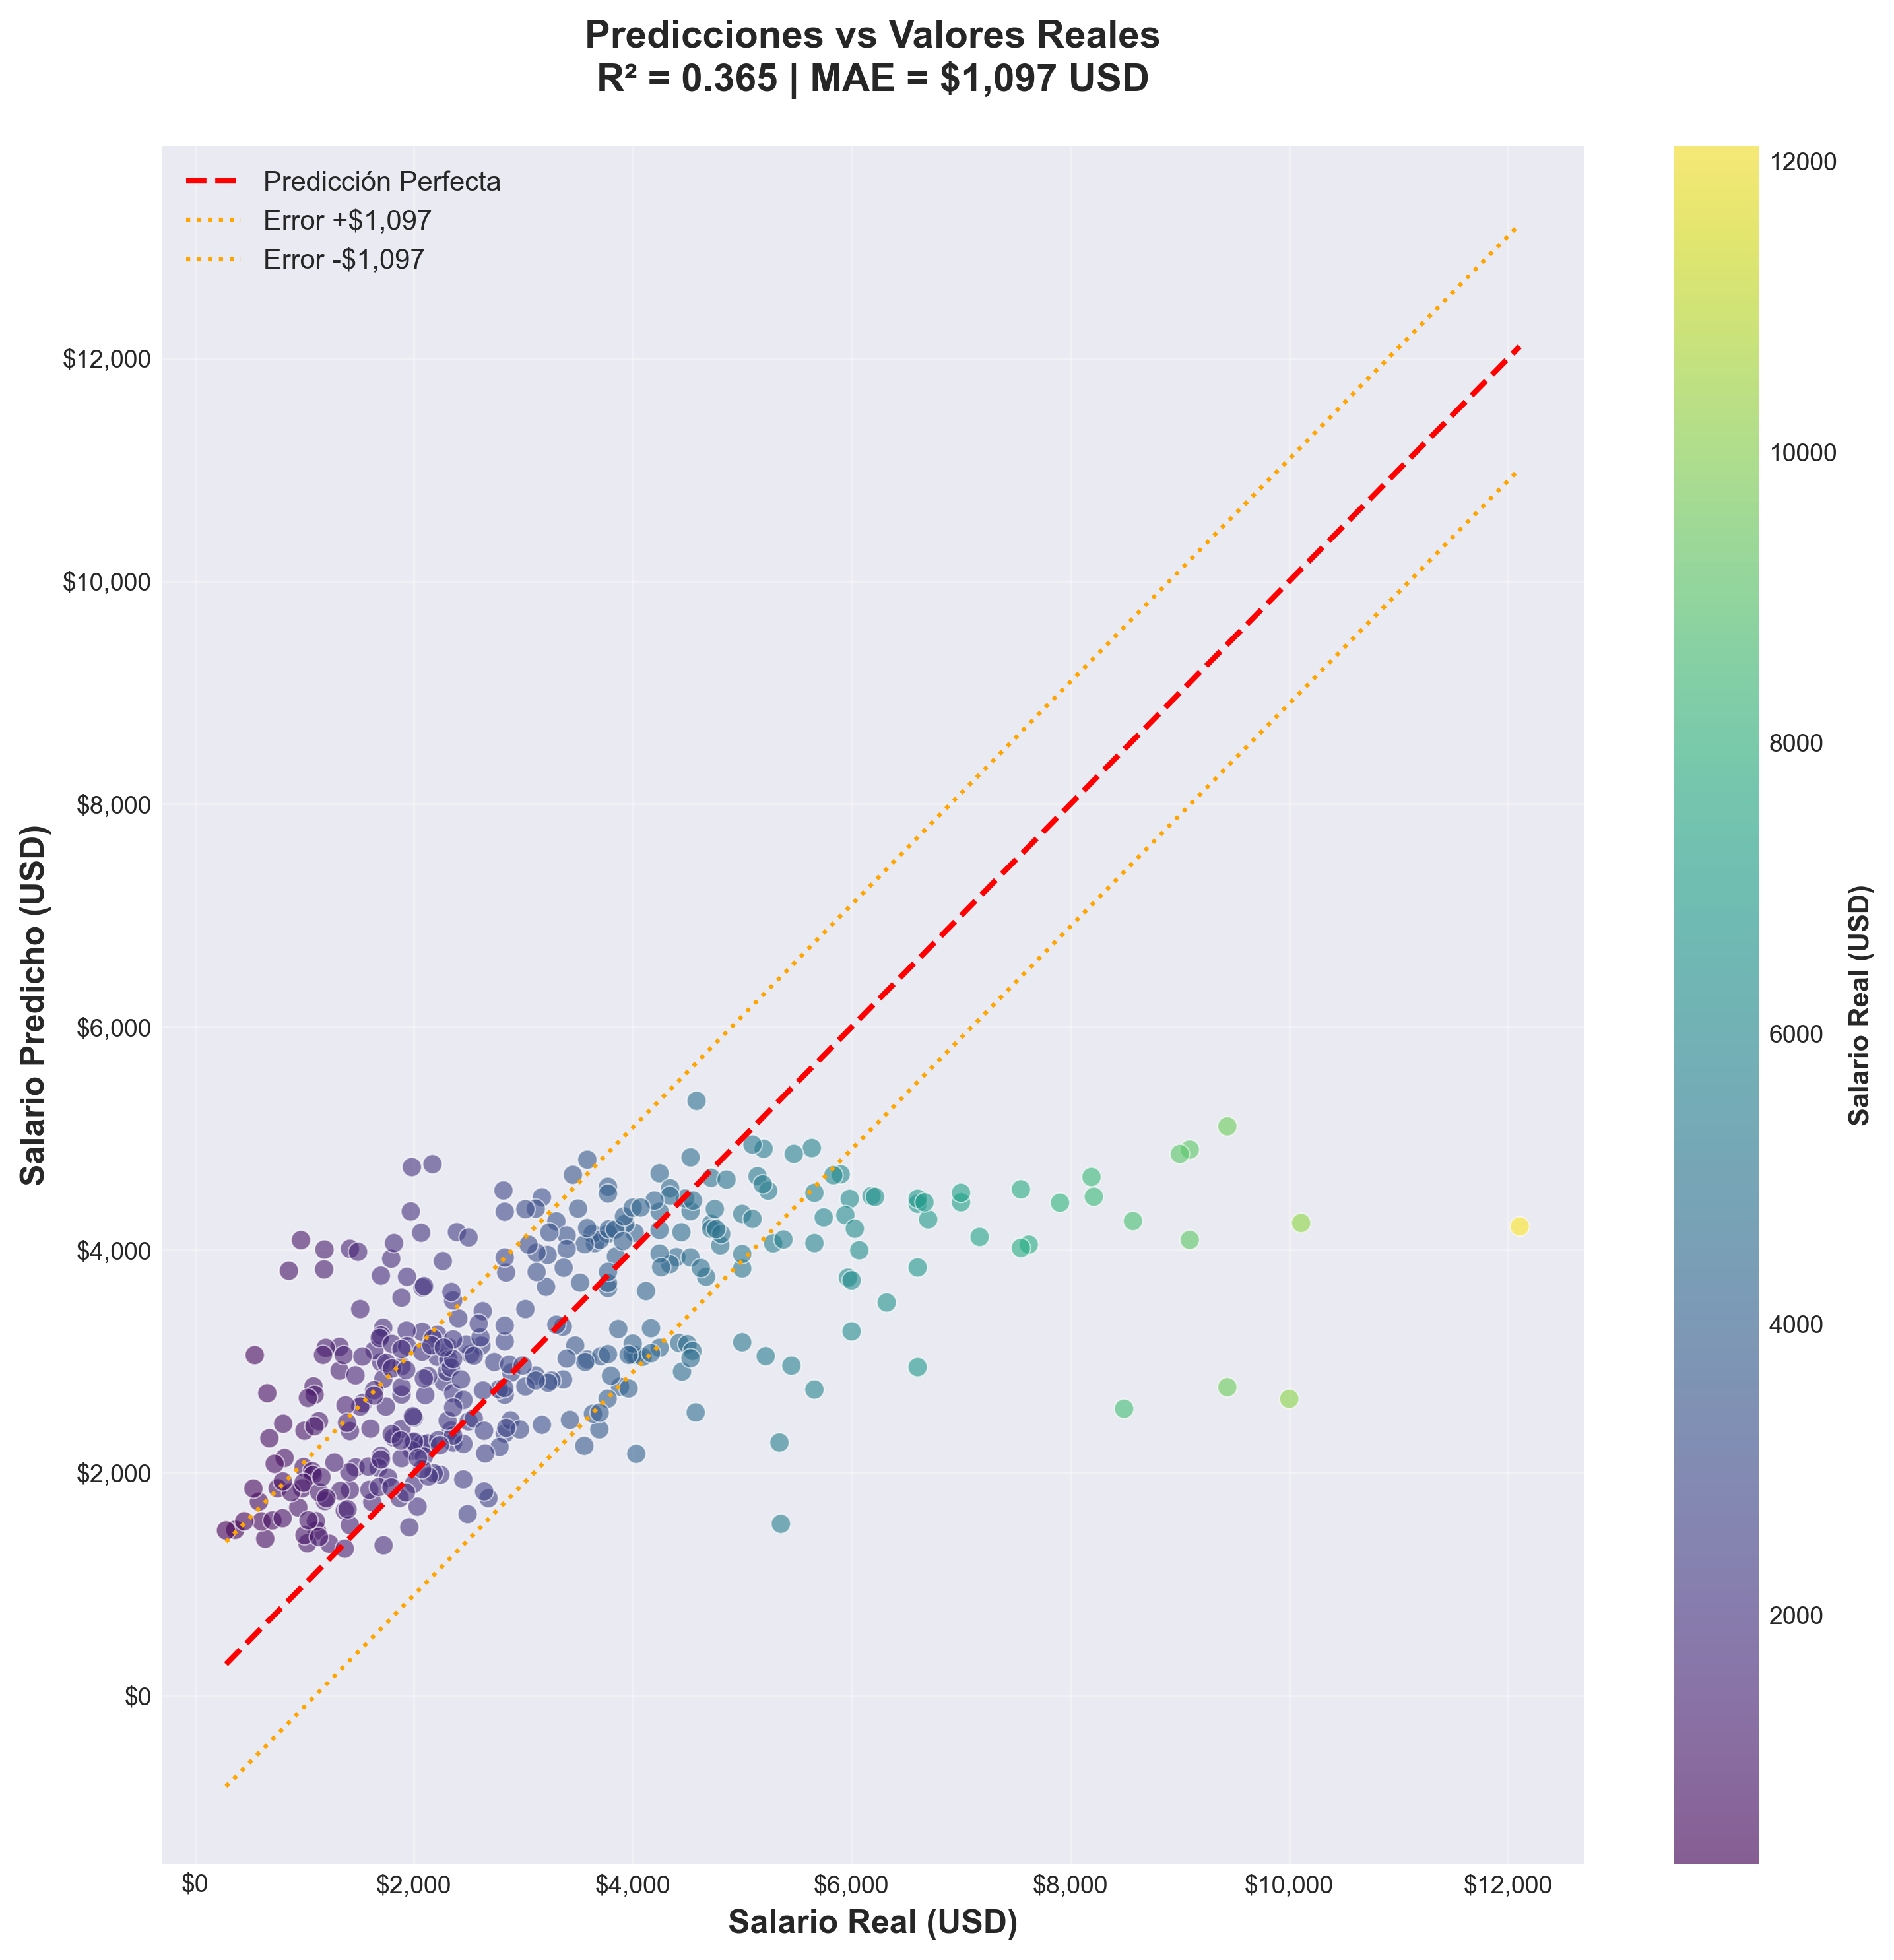

In [12]:
# Scatter plot con muestreo si hay muchos puntos
n_points = len(y_test)
if n_points > 500:
    sample_indices = np.random.choice(n_points, 500, replace=False)
    y_test_sample = y_test.iloc[sample_indices]
    y_pred_sample = y_pred_test[sample_indices]
else:
    y_test_sample = y_test
    y_pred_sample = y_pred_test

fig, ax = plt.subplots(figsize=(10, 10))

# Scatter plot
scatter = ax.scatter(y_test_sample, y_pred_sample, 
                     c=y_test_sample, cmap='viridis', 
                     s=50, alpha=0.6, edgecolors='white', linewidth=0.5)

# Línea de predicción perfecta
min_val = min(y_test.min(), y_pred_test.min())
max_val = max(y_test.max(), y_pred_test.max())
ax.plot([min_val, max_val], [min_val, max_val], 
        'r--', linewidth=2, label='Predicción Perfecta')

# Bandas de error (±MAE)
ax.plot([min_val, max_val], [min_val + mae_test, max_val + mae_test], 
        'orange', linestyle=':', linewidth=1.5, label=f'Error +${mae_test:,.0f}')
ax.plot([min_val, max_val], [min_val - mae_test, max_val - mae_test], 
        'orange', linestyle=':', linewidth=1.5, label=f'Error -${mae_test:,.0f}')

ax.set_xlabel('Salario Real (USD)', fontweight='bold', fontsize=12)
ax.set_ylabel('Salario Predicho (USD)', fontweight='bold', fontsize=12)
ax.set_title(f'Predicciones vs Valores Reales\nR² = {r2_test:.3f} | MAE = ${mae_test:,.0f} USD', 
             fontweight='bold', fontsize=14, pad=20)
ax.legend(loc='upper left', framealpha=0.9, fontsize=10)
ax.grid(True, alpha=0.3)

# Formato de ejes
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))

# Colorbar
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Salario Real (USD)', fontweight='bold')

if n_points > 500:
    ax.text(0.5, 0.02, f'Nota: Mostrando 500 de {n_points} puntos', 
            transform=ax.transAxes, ha='center', fontsize=9, 
            style='italic', color='gray')

plt.tight_layout()
plt.show()

### Cálculo de la importancia de las variables

En este caso, el modelo nos proporciona una medida de la importancia de cada variable en la predicción del salario. Podemos ordenar estas importancias y visualizarlas para identificar cuáles son las características más influyentes.

TOP 15 VARIABLES MÁS IMPORTANTES:

                                             Variable  Importancia_%
0                                         experiencia      25.301486
4                                    seniority_Senior      16.287362
23        forma_pago_Cobro todo el salario en dólares      11.255804
2                                                edad       9.608281
18                        puesto_categoria_Management       8.963168
12                     tamano_empresa_Pequeña (1-100)       4.362377
1                                          antiguedad       4.133615
3                               seniority_Semi-Senior       3.722887
25                            tiene_equipo_Sin equipo       2.774539
9             tipo_contrato_Staff (planta permanente)       2.697445
11                  tamano_empresa_Mediana (101-1000)       2.380986
24  forma_pago_Mi sueldo está dolarizado (pero cob...       1.727312
5                               modalidad_100% remoto       1.248300

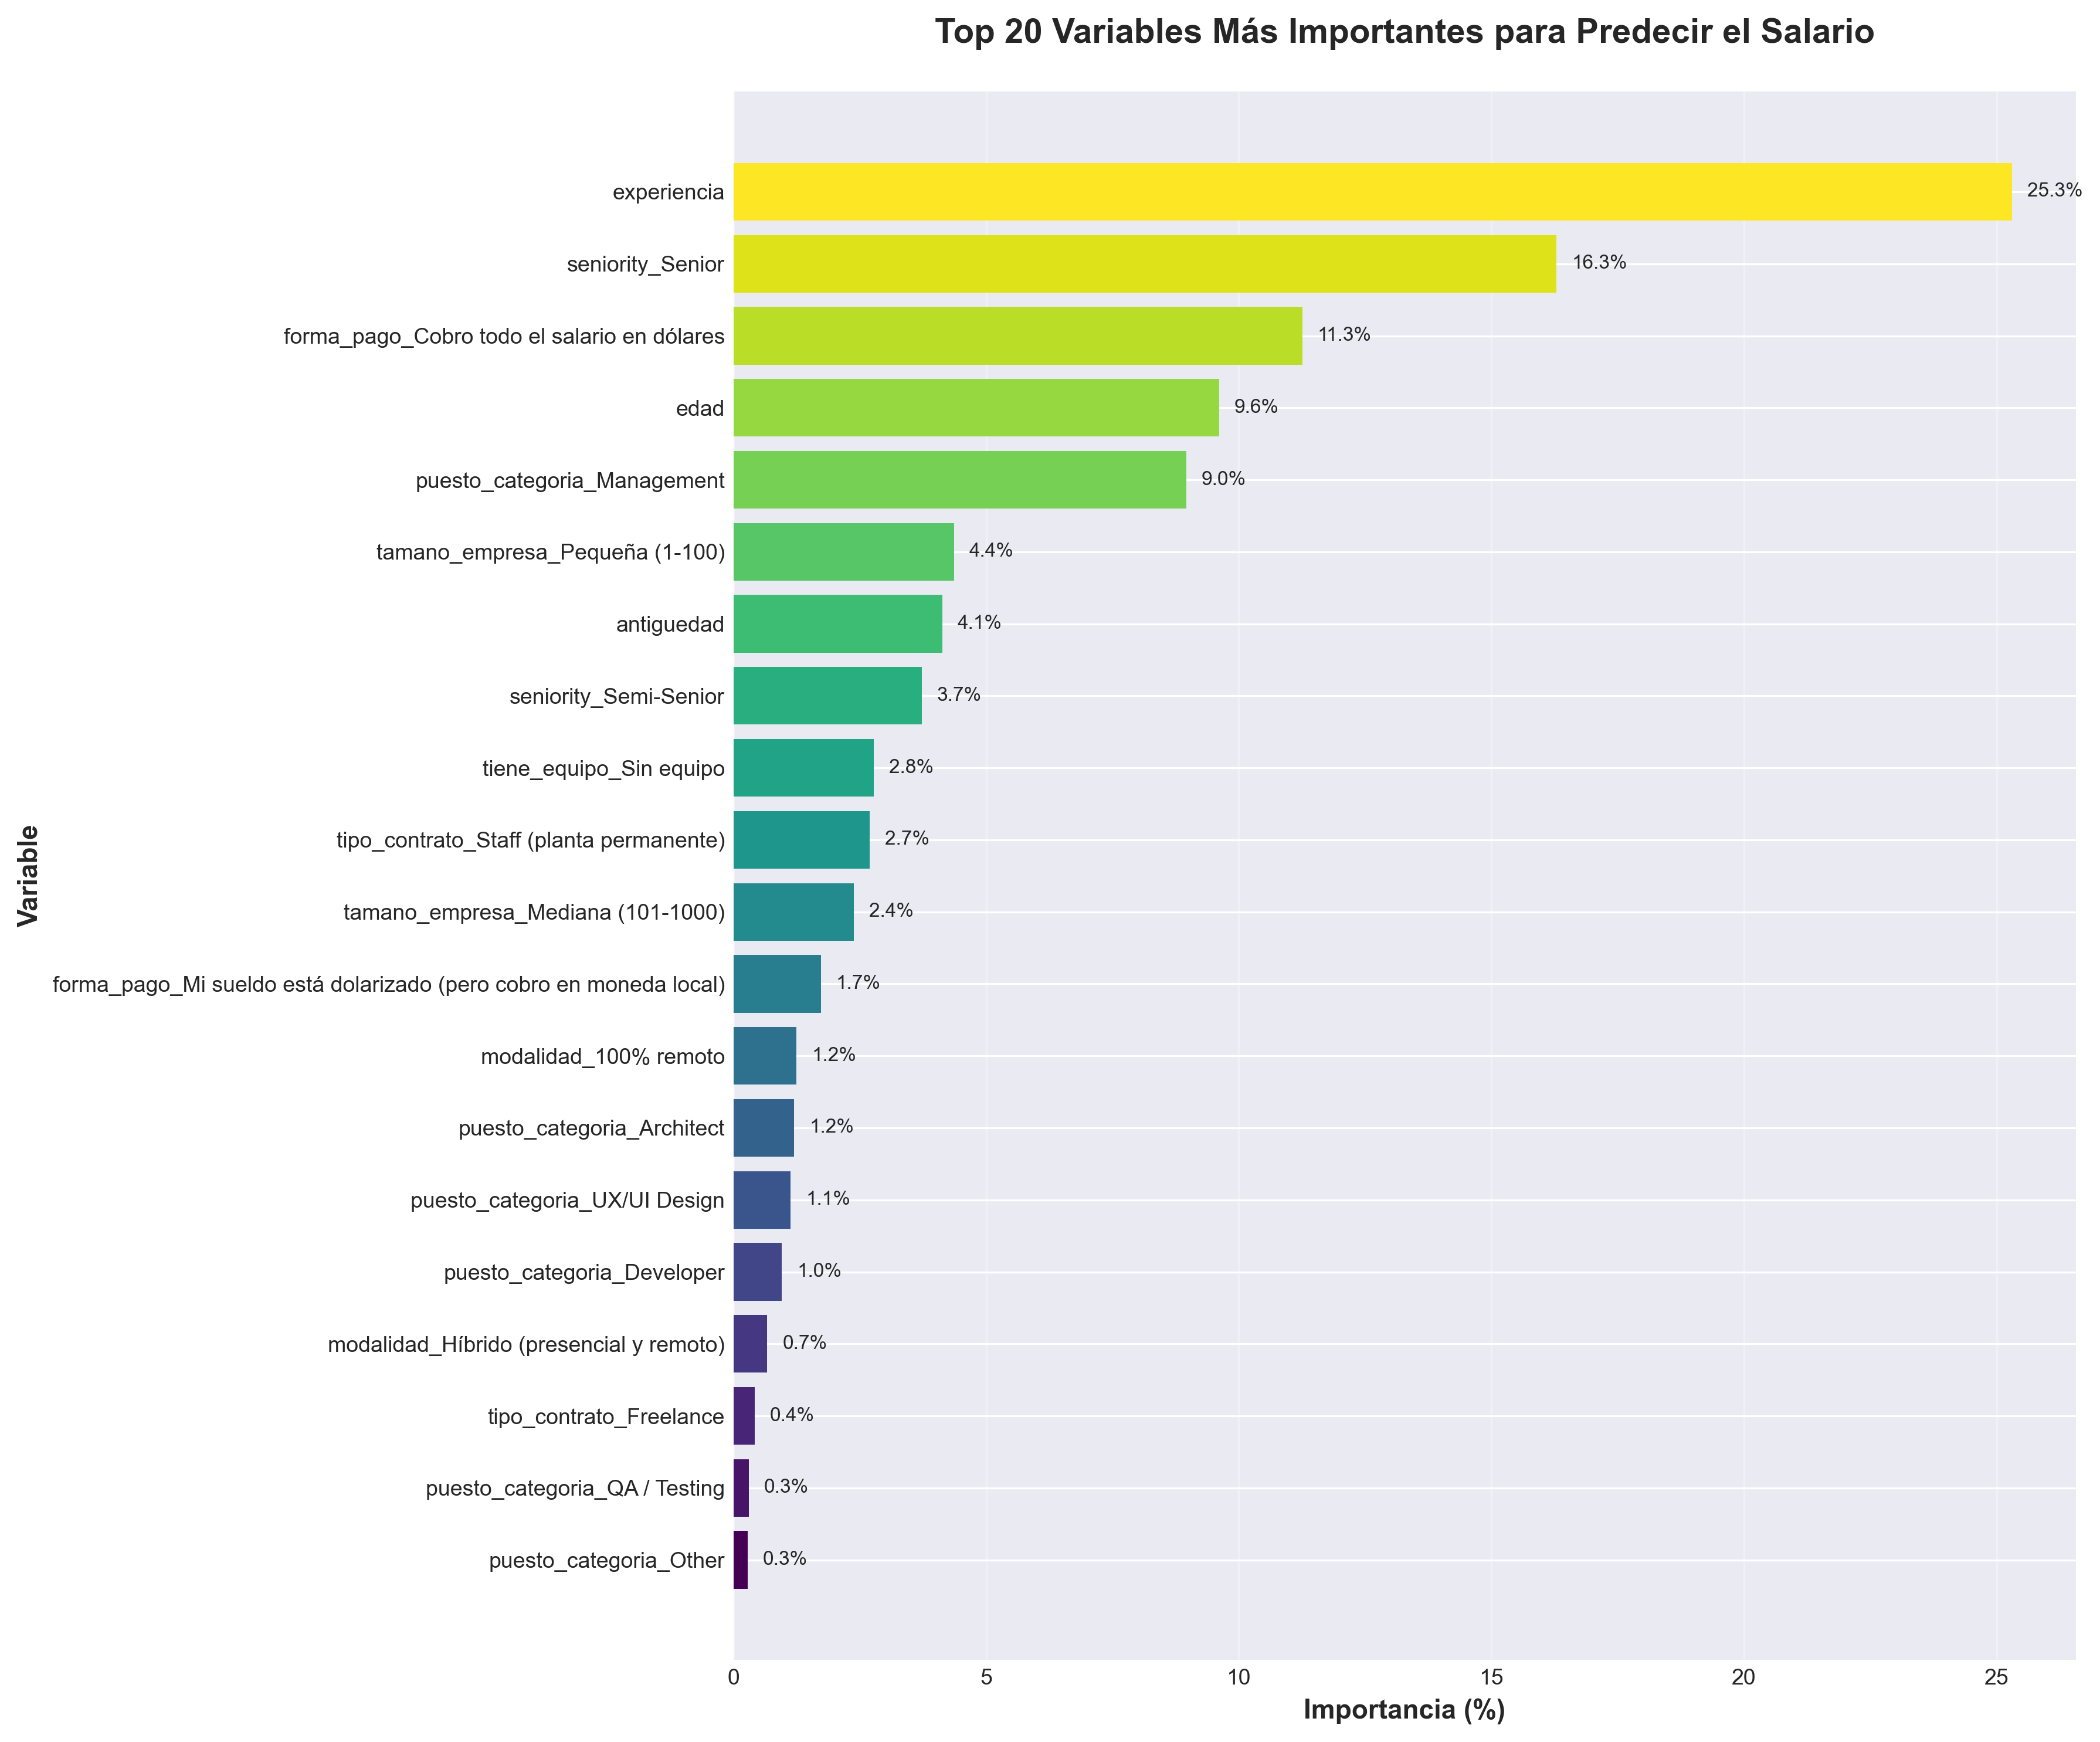

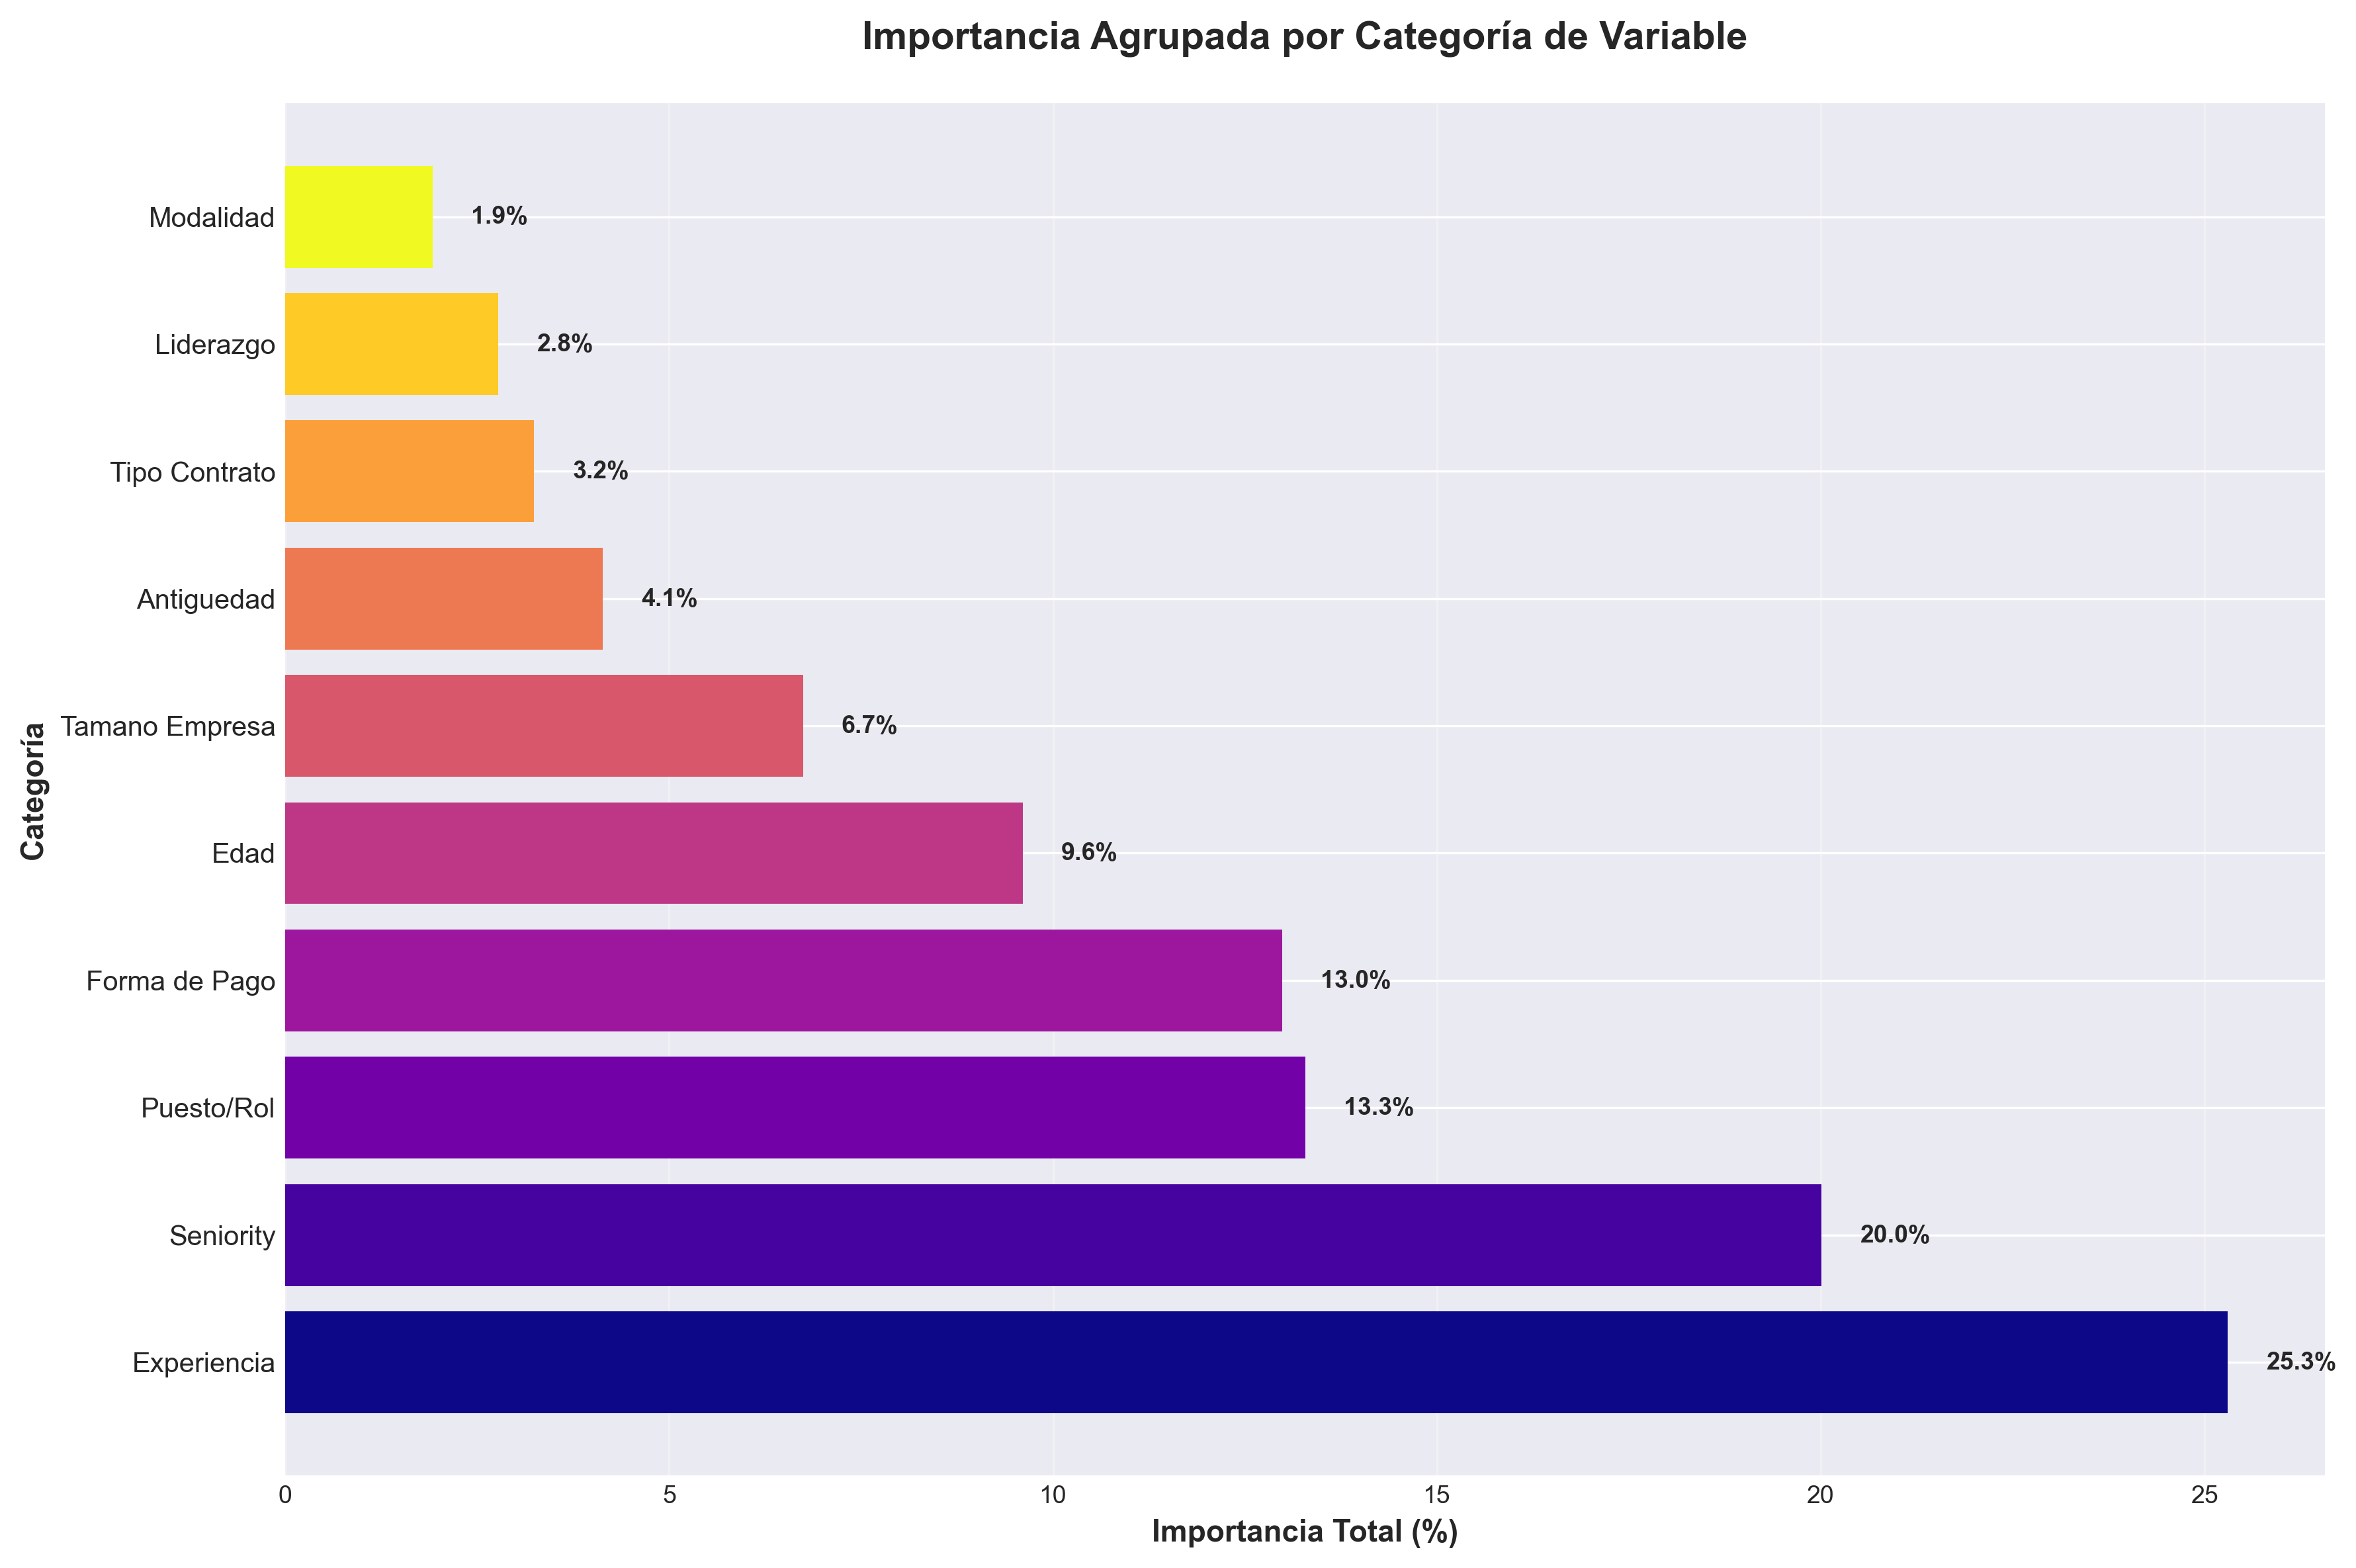

In [13]:
# Calcular importancias
importances = model.feature_importances_
feature_imp_df = pd.DataFrame({
    'Variable': feature_names,
    'Importancia_%': importances * 100
}).sort_values(by='Importancia_%', ascending=False)

print("TOP 15 VARIABLES MÁS IMPORTANTES:\n")
print(feature_imp_df.head(15))
print()

# Agrupar por categoría
def extraer_categoria(var):
    if 'seniority_' in var: return 'Seniority'
    elif 'puesto_categoria_' in var: return 'Puesto/Rol'
    elif 'modalidad_' in var: return 'Modalidad'
    elif 'tipo_contrato_' in var: return 'Tipo Contrato'
    elif 'tamano_empresa_' in var: return 'Tamano Empresa'
    elif 'forma_pago_' in var: return 'Forma de Pago'
    elif 'es_caba_' in var: return 'Ubicacion'
    elif 'tiene_equipo_' in var: return 'Liderazgo'
    elif var in ['experiencia', 'antiguedad', 'edad']: return var.capitalize()
    else: return 'Otros'

feature_imp_df['Categoria'] = feature_imp_df['Variable'].apply(extraer_categoria)
imp_agrupada = feature_imp_df.groupby('Categoria')['Importancia_%'].sum().sort_values(ascending=False)

print("IMPORTANCIA POR CATEGORÍA:\n")
print(imp_agrupada.to_frame())
print()

# Visualización: Top 20 Variables
top_20 = feature_imp_df.head(20).sort_values(by='Importancia_%', ascending=True)

fig, ax = plt.subplots(figsize=(12, 10))

y_pos = range(len(top_20))
bars = ax.barh(y_pos, top_20['Importancia_%'], 
               color=plt.cm.viridis(np.linspace(0, 1, len(top_20))))

ax.set_yticks(y_pos)
ax.set_yticklabels(top_20['Variable'], fontsize=9)
ax.set_xlabel('Importancia (%)', fontweight='bold', fontsize=11)
ax.set_ylabel('Variable', fontweight='bold', fontsize=11)
ax.set_title('Top 20 Variables Más Importantes para Predecir el Salario', 
             fontweight='bold', fontsize=14, pad=20)

# Agregar valores en las barras
for i, (bar, value) in enumerate(zip(bars, top_20['Importancia_%'])):
    ax.text(value + 0.3, bar.get_y() + bar.get_height()/2, 
            f'{value:.1f}%', va='center', fontsize=8)

ax.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()


# Visualización: Importancia Agrupada
fig, ax = plt.subplots(figsize=(12, 8))

y_pos = range(len(imp_agrupada))
bars = ax.barh(y_pos, imp_agrupada.values, 
               color=plt.cm.plasma(np.linspace(0, 1, len(imp_agrupada))))

ax.set_yticks(y_pos)
ax.set_yticklabels(imp_agrupada.index, fontsize=10)
ax.set_xlabel('Importancia Total (%)', fontweight='bold', fontsize=11)
ax.set_ylabel('Categoría', fontweight='bold', fontsize=11)
ax.set_title('Importancia Agrupada por Categoría de Variable', 
             fontweight='bold', fontsize=14, pad=20)

# Agregar valores en las barras
for i, (bar, value) in enumerate(zip(bars, imp_agrupada.values)):
    ax.text(value + 0.5, bar.get_y() + bar.get_height()/2, 
            f'{value:.1f}%', va='center', fontsize=9, fontweight='bold')

ax.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

### Análisis de residuos

Finalmente, podemos analizar los residuos del modelo, es decir, la diferencia entre los salarios reales y los predichos. Esto nos permite identificar patrones en los errores del modelo y entender mejor su rendimiento.

ESTADISTICAS DE LOS RESIDUOS:
Media: $33 USD
Mediana: $-249 USD
Desviación Estándar: $1,561 USD



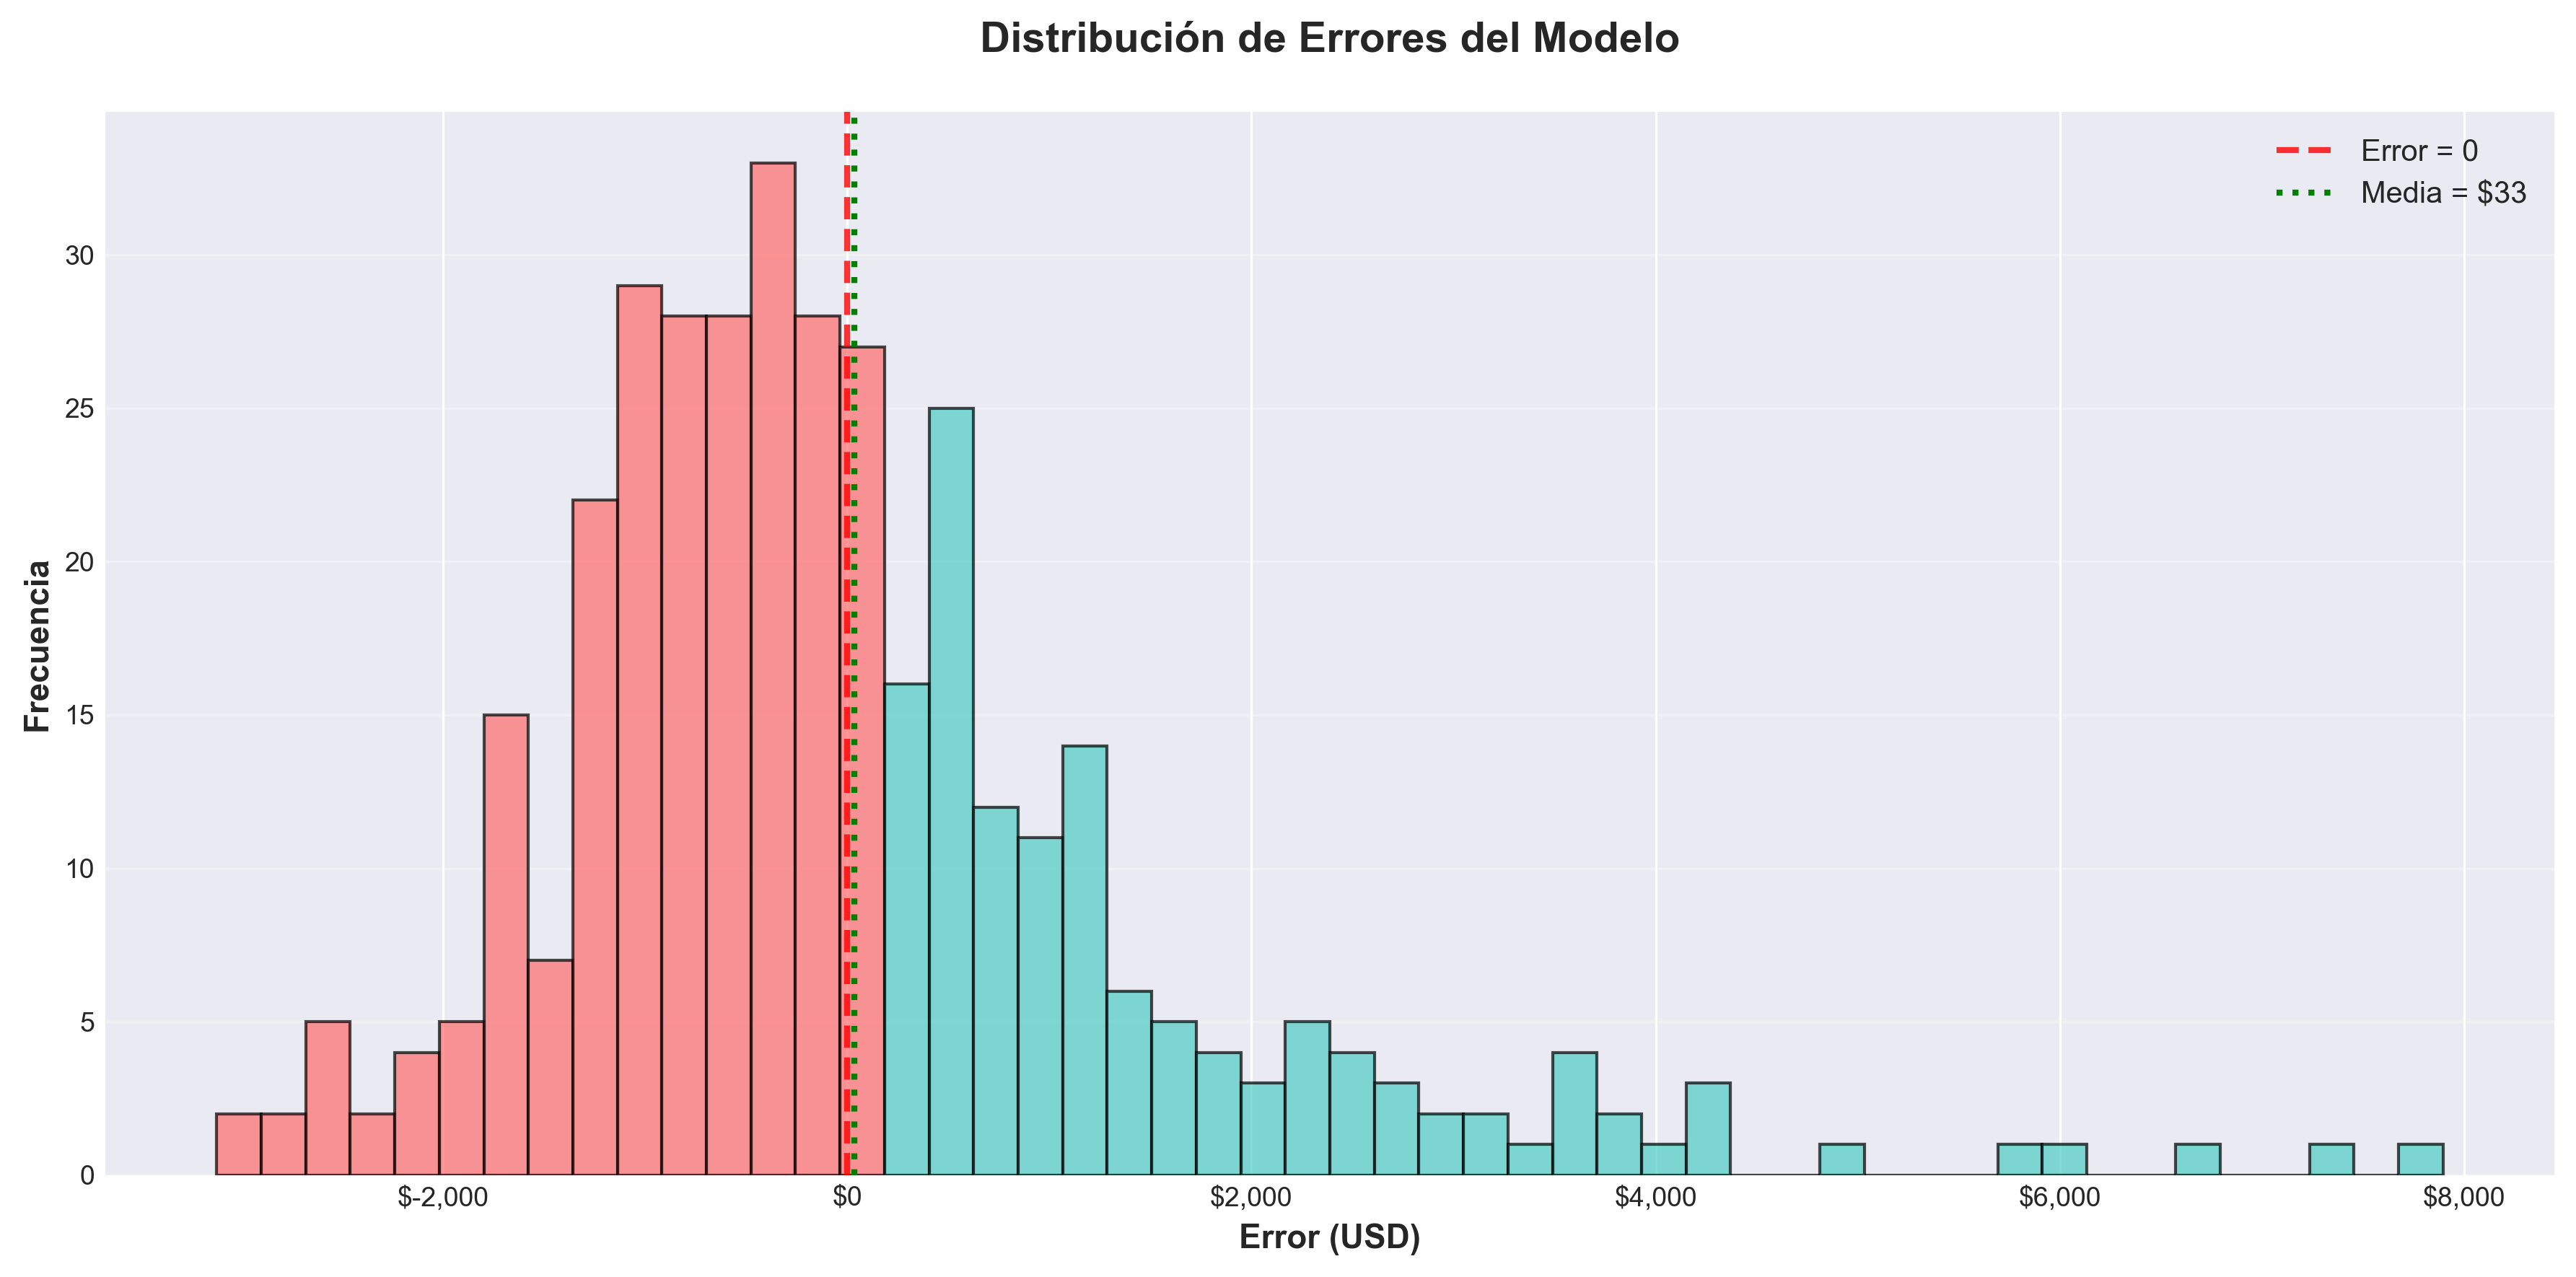

In [14]:
# Calcular residuos
residuos = y_test - y_pred_test

print("ESTADISTICAS DE LOS RESIDUOS:")
print(f"Media: ${residuos.mean():,.0f} USD")
print(f"Mediana: ${residuos.median():,.0f} USD")
print(f"Desviación Estándar: ${residuos.std():,.0f} USD\n")

# Distribución de residuos
fig, ax = plt.subplots(figsize=(12, 6))

n, bins, patches = ax.hist(residuos, bins=50, color='steelblue', 
                            alpha=0.7, edgecolor='black')

# Colorear barras según valor
for i, patch in enumerate(patches):
    if bins[i] < 0:
        patch.set_facecolor('#FF6B6B')
    elif bins[i] > 0:
        patch.set_facecolor('#4ECDC4')
    else:
        patch.set_facecolor('gold')

ax.axvline(x=0, color='red', linestyle='--', linewidth=2, 
           label='Error = 0', alpha=0.8)
ax.axvline(x=residuos.mean(), color='green', linestyle=':', 
           linewidth=2, label=f'Media = ${residuos.mean():,.0f}')

ax.set_xlabel('Error (USD)', fontweight='bold', fontsize=11)
ax.set_ylabel('Frecuencia', fontweight='bold', fontsize=11)
ax.set_title('Distribución de Errores del Modelo', 
             fontweight='bold', fontsize=14, pad=20)
ax.legend(loc='upper right', framealpha=0.9)
ax.grid(axis='y', alpha=0.3)
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))

plt.tight_layout()
plt.show()

### Conclusiones del modelo de Machine Learning

El modelo identifica correctamente que la experiencia, edad y forma de pago en dólares son los predictores más importantes del salario. Esto coincide con nuestro análisis previo, donde también destacamos estas variables como parte de la combinación ganadora. De esta forma validamos nuestras conclusiones y reforzamos la idea de que estas características son clave para maximizar el salario en el sector IT.

In [15]:
top_cat = imp_agrupada.index[0]
top_val = imp_agrupada.iloc[0]

print(f"""
El modelo Random Forest revela que:

* Precision (R² test): {r2_test:.1%} - Explica {r2_test*100:.1f}% de la variabilidad salarial
* Precision (R² CV): {cv_scores.mean():.1%} - Validación cruzada confirma estabilidad
* Error promedio: ${mae_test:,.0f} USD/mes (±${cv_mae.std():,.0f})
* Overfitting: {'Controlado' if diff_r2 < 0.2 else 'Presente'} (diferencia R²: {diff_r2:.3f})
* Factor mas determinante: {top_cat} ({top_val:.1f}% de importancia)

Top 3 variables individuales:
1. {feature_imp_df.iloc[0]['Variable']}: {feature_imp_df.iloc[0]['Importancia_%']:.2f}%
2. {feature_imp_df.iloc[1]['Variable']}: {feature_imp_df.iloc[1]['Importancia_%']:.2f}%
3. {feature_imp_df.iloc[2]['Variable']}: {feature_imp_df.iloc[2]['Importancia_%']:.2f}%
""")


El modelo Random Forest revela que:

* Precision (R² test): 36.5% - Explica 36.5% de la variabilidad salarial
* Precision (R² CV): 34.5% - Validación cruzada confirma estabilidad
* Error promedio: $1,097 USD/mes (±$56)
* Overfitting: Controlado (diferencia R²: 0.046)
* Factor mas determinante: Experiencia (25.3% de importancia)

Top 3 variables individuales:
1. experiencia: 25.30%
2. seniority_Senior: 16.29%
3. forma_pago_Cobro todo el salario en dólares: 11.26%



## Conclusiones

A modo de cierre, luego del EDA ("Análisis exploratorio de Datos") y del análisis utilizando Machine Learning, podemos llegar a la conclusión de que la mejor combinación de variables para maximizar el salario en el sector IT es la siguiente: en primer lugar, la experiencia laboral. Podríamos decir que "cuanto antes, mejor", es decir, comenzar a trabajar lo antes posible para acumular experiencia, incluso mientras se está estudiando, ya que no parece ser un mercado laboral que exija títulos universitarios para acceder a mejores salarios. La mejora constante sí es algo necesario pero no necesariamente a través de títulos formales. La dolarización del salario también es un factor clave, ya que los salarios en dólares tienden a ser más altos en comparación con los salarios en moneda local. Por último, algo que también está vinculado con la seniority/experiencia es el liderazgo, aquellas personas con "gente a cargo" que dirigen equipos suelen tener salarios más altos. Esta última variable se vincula directamente con las llamadas "soft skills", lo que coincide con la tendencia actual del mercado laboral a valorar cada vez más estas habilidades interpersonales y de gestión. 